In [1]:
import numpy as np
import pandas as pd
import re

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.models import fasttext 
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from nltk import TweetTokenizer
from nltk.corpus import stopwords

from gensim.parsing.porter import PorterStemmer

from collections import Counter

from timeit import default_timer as timer
import emoji

pd.options.display.float_format = '{:,.4f}'.format # Formatting for statistics
SPLIT_SIZE = 0.8 # Train-Test-Split

### Load Glove
Pretrained GloVe-Embeddings, trained on twitter data (27B tokens) over 50 dimensions

In [3]:
start = timer()
glove_file = datapath("C:/Users/flohk/OneDrive/Uni/Projektseminar/data/GloVe/glove.twitter.27B.50d.txt")
tmp_file = get_tmpfile("C:/Users/flohk/OneDrive/Uni/Projektseminar/data/GloVe/test_word2vec.txt")
_ = glove2word2vec(glove_file, tmp_file)
model = KeyedVectors.load_word2vec_format(tmp_file)
end = timer()
end - start

C:\Users\flohk\AppData\Local\Temp/ipykernel_4848/990565478.py:4: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  _ = glove2word2vec(glove_file, tmp_file)


128.46228739999998

### Load Fasttext vectors
Pretrained Fasttext-Embeddings (common crawl) over 300 dimensions

In [2]:
start = timer()
fasttext_vecs = datapath("C:/Users/flohk/OneDrive/Uni/Projektseminar/data/crawl-300d-2M-subword/crawl-300d-2M-subword.bin")
fasttxt = fasttext.load_facebook_vectors(fasttext_vecs)
end = timer()
end - start

83.9577233

### Load twitter data
Data from https://github.com/GT-SALT/implicit-hate
Any explicit hate is filtered out so that there is only non-explicit hate and non-explicit non-hate left. 

In [2]:
df = pd.read_csv("data/implicit-hate-corpus/implicit_hate_v1_stg1_posts.tsv", delimiter="\t")
df_id = pd.read_csv("data/implicit-hate-corpus/implicit_hate_v1_stg1.tsv", delimiter="\t")
df["ID"] = df_id["ID"]
df = df[df["class"] != "explicit_hate"]
df_class = pd.read_csv("data/implicit-hate-corpus/implicit_hate_v1_stg2.tsv", delimiter="\t")
df = pd.merge(df, df_class, on="ID", how="left")
display(df)

,post,class,ID,implicit_class,extra_implicit_class
0,""" : jewish harvard professor noel ignatiev w...",implicit_hate,399886440588247041,white_grievance,NaN
1,b.higher education is a part of european cult...,not_hate,929901925100937216,NaN,NaN
2,"has a problem with "" the whites "" "" and "" "" ...",not_hate,728678509497954304,NaN,NaN
3,is yasir qadhi a hate preacher for calling ch...,not_hate,625688620444180481,NaN,NaN
4,"rt "" : how three million germans mass murder...",not_hate,441089979322597376,NaN,NaN
...,...,...,...,...,...
20386,"Seeing prostitutes is morally wrong, but being...",implicit_hate,SAP_17154,irony,NaN
20387,I wonder how many females I raped today I spen...,implicit_hate,SAP_17179,irony,NaN
20388,Having a criminal record is more attractive to...,implicit_hate,SAP_17314,stereotypical,NaN
20389,Another advantage of being a female: getting b...,implicit_hate,SAP_17343,inferiority,NaN


### Load Gab Data
Data from https://osf.io/edua3/
Here, explicit hate is filtered out as well, so that there is only implicit hate and non-hate left

In [8]:
df2 = pd.read_csv("data/GabHateCorpus_annotations.tsv", delimiter="\t")
display("Hate without duplicates: " + str(Counter(df2["Hate"])))
df2 = df2[df2["EX"] != 1] # Filter out explicit hate
df2["IM"].fillna(0, inplace=True)
display("Implicit with duplicates :  " + str(Counter(df2["IM"])))
df2.drop_duplicates(subset="Text", inplace=True) # Use first entry
display("Implicit without duplicates :  " + str(Counter(df2["IM"])))
display("Hate without duplicates :  " + str(Counter(df2["Hate"])))
df2

'Hate without duplicates: Counter({0: 75280, 1: 11249})'

'Implicit with duplicates :  Counter({0.0: 76327, 1.0: 3896})'

'Implicit without duplicates :  Counter({0.0: 25536, 1.0: 1793})'

'Hate without duplicates :  Counter({0: 25119, 1: 2210})'

,ID,Annotator,Text,Hate,HD,CV,VO,REL,RAE,SXO,GEN,IDL,NAT,POL,MPH,EX,IM
0,27044,4,Ah the PSYOPS antifa crew is back. That’s how ...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000
4,27045,4,Get the new Android app update released today ...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000
7,27046,4,Study: Google Pushes Liberal News in Top 5 Sea...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000
11,27048,4,#Breaking: Claiming bias against conservatives...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000
15,27049,4,"“These [companies] are run by sociopaths,” he ...",0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86514,7132,11,yeah we wont be deleting these accounts so neo...,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000
86518,9078,12,"Wow, watch this yarmie wearing Jew brag about ...",0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000
86520,9167,5,I'm available as a Common Sense Consultant sin...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000
86523,9188,11,"He thinks only peons own guns, you're supposed...",0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000


### Vectorizer
Big function for generating the input vectors for training and testing. Differenct features can be selected parametrically

In [4]:
tokenizer = TweetTokenizer()
stemmer = PorterStemmer()
stop = stopwords.words("English")
caps_tokens = re.compile(r"\w+(?:'\w+)?|[^\w\s]")

def vectorize(sent, clean_input=['"'], features=["word2vec"]):
    
    # Remove unwanted substrings from input
    for subs in clean_input:
        sent = sent.replace(subs, "")
    
    feature_vector = []
    
    # Glove vectors
    if "word2vec" in features:
        tokens = [stemmer.stem(token.lower()) for token in tokenizer.tokenize(sent) if token.isalpha() and token not in stop]
        vecs = np.zeros(50)
        valid_toks = 0
        for token in tokens:
            try:
                vecs += model.get_vector(token)
                valid_toks += 1
            except KeyError:
                print("not found:", token)
                pass
        if valid_toks != 0:
            # vecs = vecs / np.sqrt((vecs * vecs).sum()) # Alternative averaging which is worse!
            vecs = vecs / valid_toks
        feature_vector += list(vecs)
    
    # Fasttext vectors
    if "fasttext" in features:
        tokens = [token for token in tokenizer.tokenize(sent) if token not in stop]
        vecs = np.zeros(300)
        for token in tokens:
            vecs += fasttxt[token]
        if len(tokens) != 0:
            vecs = vecs / len(tokens)
        feature_vector += list(vecs)
    
    # Doc2Vec vectors
    if "doc2vec twitter" in features:
        tokens = [stemmer.stem(token.lower()) for token in tokenizer.tokenize(sent) if token.isalpha() and token not in stop]
        feature_vector += list(twitter_doc2vec_model.infer_vector(tokens))
    
    if "doc2vec gab" in features:
        tokens = [stemmer.stem(token.lower()) for token in tokenizer.tokenize(sent) if token.isalpha() and token not in stop]
        feature_vector += list(gab_doc2vec_model.infer_vector(tokens))
    
    # Punctuation counts marks
    if "punctuation" in features:
        puncts = []
        puncts.append(sent.count("."))
        puncts.append(sent.count("..."))
        puncts.append(sent.count(","))
        puncts.append(sent.count("("))
        puncts.append(sent.count(")"))
        puncts.append(sent.count(":"))
        puncts.append(sent.count(";"))
        puncts.append(sent.count('"'))
        feature_vector += puncts
        
    # Hashtag count
    if "hashtag" in features:
        feature_vector += [sent.count("#")]
        
    # Is Retweet
    if "retweet" in features:
        retweet = []
        if "b'RT " in sent or "bRT " in sent or " rt " in sent:
            retweet.append(1)
        else:
            retweet.append(0)
        feature_vector += retweet
        
    # ratio of words in all caps
    if "caps" in features:
        filterwords = [token for token in caps_tokens.findall(sent) if token.isalpha() and len(token) > 1]
        caps = [word for word in filterwords if word.isupper()]
        if len(filterwords) > 0:
            ratio = len(caps) / len(filterwords)
        else:
            ratio = 0
        feature_vector += [ratio]
    
    # Emoji count
    if "emoji" in features:
        emojis = 0
        for char in sent:
            if emoji.is_emoji(char):
                emojis += 1
        feature_vector += [emojis]
        
    
    return np.array(feature_vector)

### GloVe data feeding
Creating the gold labels (binary classification: hate vs non-hate) and running the input features for the GloVe-based classifiers through a scaler which helps some of the classifiers, since the features are of different dimensions and means

In [3]:
twitter_binary_labels = np.array(df['class'] == "implicit_hate")

In [ ]:
twitter_binary_features = np.array([vectorize(tweet) for tweet in df["post"]])
tweet_scaler = StandardScaler()
tweet_scaler.fit(twitter_binary_features[:int(len(twitter_binary_features)*SPLIT_SIZE)])
twitter_binary_features = tweet_scaler.transform(twitter_binary_features)

twitter_binary_features_complex = np.array([vectorize(tweet, features=["word2vec", "punctuation", "hashtag", "retweet", "caps", "emoji"]) for tweet in df["post"]])
tweet_scaler_complex = StandardScaler()
tweet_scaler_complex.fit(twitter_binary_features_complex[:int(len(twitter_binary_features_complex)*SPLIT_SIZE)])
twitter_binary_features_complex = tweet_scaler_complex.transform(twitter_binary_features_complex)

In [ ]:
gab_binary_labels = np.array(df2['Hate'] == 1.0)

In [16]:
gab_binary_features = np.array([vectorize(post) for post in df2["Text"]])
gab_scaler = StandardScaler()
gab_scaler.fit(gab_binary_features[:int(len(gab_binary_features)*SPLIT_SIZE)])
gab_binary_features = gab_scaler.transform(gab_binary_features)

gab_binary_features_complex = np.array([vectorize(post, features=["word2vec", "punctuation", "hashtag", "retweet", "caps", "emoji"]) for post in df2["Text"]])
gab_scaler_complex = StandardScaler()
gab_scaler_complex.fit(gab_binary_features_complex[:int(len(gab_binary_features_complex)*SPLIT_SIZE)])
gab_binary_features_complex = gab_scaler_complex.transform(gab_binary_features_complex)

not found: psyop
not found: endur
not found: empow
not found: loomer
not found: allsup
not found: badg
not found: howdi
not found: quicki
not found: unexpect
not found: surgeri
not found: amput
not found: surgeri
not found: hagborg
not found: kleitsch
not found: florenc
not found: kleitsch
not found: kleitsch
not found: kleitsch
not found: chaouki
not found: chevk
not found: teachabl
not found: nonam
not found: enterpris
not found: deplor
not found: truli
not found: mctraitor
not found: translat
not found: translat
not found: missimg
not found: darkmod
not found: foreplai
not found: honesti
not found: lefti
not found: timescal
not found: paralyz
not found: paralyz
not found: omnibu
not found: degener
not found: ozzi
not found: inflat
not found: alwai
not found: reluctantli
not found: embrac
not found: cheesi
not found: inflat
not found: obliter
not found: leftw
not found: indoctrin
not found: muzzl
not found: lunaci
not found: seemingli
not found: adject
not found: punctuat
not found: 

not found: exasper
not found: cucked
not found: asinin
not found: unfortun
not found: hillari
not found: assang
not found: superpow
not found: bundl
not found: warhamm
not found: konosuba
not found: awhil
not found: yesterdai
not found: honestli
not found: konosuba
not found: artemi
not found: defac
not found: ocument
not found: getelementbyid
not found: webtorr
not found: greatawaken
not found: quickli
not found: asatru
not found: mememeist
not found: trumper
not found: peddal
not found: conspiraci
not found: killari
not found: viabl
not found: anybodi
not found: disguis
not found: negoti
not found: ironybro
not found: alwai
not found: warrenti
not found: conspiratard
not found: dramadon
not found: somedai
not found: catboi
not found: alwai
not found: homosexu
not found: strongli
not found: deploi
not found: centuri
not found: cathol
not found: boogiti
not found: wahhhhh
not found: defam
not found: wahhhhh
not found: unfortun
not found: exactli
not found: hillari
not found: nxivm
not 

not found: paedophil
not found: versu
not found: birthrat
not found: exodu
not found: gayyyi
not found: relentlessli
not found: audianc
not found: fluorid
not found: classifi
not found: neurotoxin
not found: plzzagat
not found: satanlc
not found: rltual
not found: invad
not found: timothi
not found: triag
not found: triag
not found: optimu
not found: catalunyan
not found: friendli
not found: betrai
not found: catalunyan
not found: independantist
not found: advers
not found: incarn
not found: headlin
not found: collus
not found: truli
not found: guilti
not found: anywai
not found: supervillian
not found: thano
not found: overtax
not found: convinc
not found: convinc
not found: yesterdai
not found: enforc
not found: facetim
not found: mostli
not found: screwi
not found: collaps
not found: voltair
not found: despis
not found: illiteraci
not found: cognit
not found: existenti
not found: grammat
not found: implod
not found: baltimor
not found: predat
not found: certainli
not found: misguid


not found: gabtv
not found: gabtv
not found: gabtv
not found: donkeybal
not found: incept
not found: crappi
not found: warski
not found: collaps
not found: clearli
not found: dispossess
not found: degener
not found: worthi
not found: religionist
not found: painshil
not found: surrei
not found: centuri
not found: landscap
not found: redpil
not found: documentari
not found: johnni
not found: elsewher
not found: normiecon
not found: unlik
not found: sensibl
not found: irration
not found: theoriz
not found: prioriti
not found: unsettl
not found: entrench
not found: kikebart
not found: headlin
not found: principl
not found: intermediari
not found: liabil
not found: outlin
not found: classifi
not found: delai
not found: wednesdai
not found: raytrac
not found: bodyslid
not found: visibl
not found: lutri
not found: bodyslid
not found: visibl
not found: lutri
not found: illeg
not found: teleprompt
not found: alwai
not found: hypocrisi
not found: fluorid
not found: assang
not found: fluorid
not 

not found: pewtub
not found: coinhiv
not found: authedmin
not found: mixtur
not found: voat
not found: fuell
not found: ratatouil
not found: honestli
not found: intrigu
not found: assang
not found: bombshel
not found: gatewai
not found: truli
not found: outrag
not found: mcinn
not found: infowar
not found: nightmar
not found: chuckl
not found: ramsei
not found: daili
not found: extermin
not found: starvat
not found: emaci
not found: significantli
not found: philosophi
not found: disgrac
not found: freeli
not found: shread
not found: constitut
not found: significantli
not found: typographi
not found: typographi
not found: readabl
not found: enforc
not found: deplor
not found: reincarn
not found: reincarn
not found: saturdai
not found: decod
not found: babybylon
not found: tribalist
not found: mundan
not found: ohhhh
not found: infowar
not found: whiskei
not found: hopefulli
not found: migrat
not found: convinc
not found: johnni
not found: whomst
not found: underestim
not found: ohtani
n

not found: scriptur
not found: jewri
not found: abednego
not found: diagnost
not found: constantli
not found: constitut
not found: overwhelmingli
not found: shitlib
not found: obei
not found: behavi
not found: warfar
not found: malwar
not found: roulett
not found: malwar
not found: atmospher
not found: abzu
not found: firewatch
not found: gameplai
not found: nekopara
not found: paheal
not found: subscript
not found: globohomo
not found: gayplex
not found: globohomo
not found: authent
not found: checkmat
not found: nahtze
not found: niggerbal
not found: headwai
not found: captiv
not found: captiv
not found: wrightsvil
not found: melber
not found: melber
not found: skincar
not found: proudli
not found: westworld
not found: djawadi
not found: inbr
not found: exactli
not found: shadowban
not found: easili
not found: heavili
not found: filthi
not found: degener
not found: nehlen
not found: unfortun
not found: unfinish
not found: amirit
not found: elabor
not found: exactli
not found: riddanc

not found: wiemar
not found: deplatform
not found: infowar
not found: allsup
not found: lapidu
not found: plagu
not found: demograph
not found: monthli
not found: prosecut
not found: whatsoev
not found: purg
not found: alwai
not found: constitut
not found: outcri
not found: rhetor
not found: unprecedentedli
not found: commonli
not found: inevit
not found: lefti
not found: accur
not found: contribut
not found: restitut
not found: deterr
not found: unelect
not found: buhrfeind
not found: clairebuhrfeind
not found: goofbal
not found: weightlift
not found: briancon
not found: pacif
not found: mostli
not found: slowli
not found: infract
not found: bewar
not found: repuls
not found: hillari
not found: vastli
not found: peoni
not found: alatwitt
not found: authorit
not found: qualifi
not found: sampl
not found: assumpt
not found: grenel
not found: haspel
not found: miscalcul
not found: atmospher
not found: mcconnel
not found: patienc
not found: gloriou
not found: airlin
not found: phillipin
n

not found: controversi
not found: theori
not found: unparallel
not found: equival
not found: ideolog
not found: blatantli
not found: catchi
not found: marketplac
not found: malevol
not found: freeli
not found: societi
not found: enforc
not found: reciproc
not found: lifesav
not found: aggress
not found: silli
not found: irrelev
not found: rucku
not found: perfectli
not found: shitti
not found: desegreg
not found: centuri
not found: relev
not found: relev
not found: anywai
not found: gullibl
not found: suffrag
not found: dialogu
not found: stubbornli
not found: tepesblog
not found: tepesblog
not found: tepesblog
not found: tepesblog
not found: carlqvist
not found: fakenew
not found: saniti
not found: cathol
not found: legitimaci
not found: violat
not found: illeg
not found: regab
not found: cathol
not found: baltimor
not found: demograph
not found: matchmak
not found: secretli
not found: lifestyl
not found: unnatur
not found: healthi
not found: alwai
not found: harridan
not found: submi

not found: primari
not found: illeg
not found: taxpay
not found: fleec
not found: hundr
not found: expens
not found: expens
not found: expens
not found: alwai
not found: bereav
not found: unfram
not found: immut
not found: bunti
not found: nonpolog
not found: bluecheck
not found: bluecheck
not found: furiou
not found: qanon
not found: treasur
not found: qanon
not found: nutcas
not found: induc
not found: thankfulli
not found: stargat
not found: supposedli
not found: supposedli
not found: unspokenli
not found: aggress
not found: immatur
not found: glyphos
not found: weedkil
not found: acquir
not found: privaci
not found: historyth
not found: alwai
not found: invinc
not found: alwai
not found: alwai
not found: healthi
not found: nutrit
not found: blueberri
not found: postmenopaus
not found: shitti
not found: aaaaawww
not found: assimil
not found: obuma
not found: percentag
not found: delud
not found: disprov
not found: clearli
not found: fulli
not found: vulner
not found: anywai
not foun

not found: dishonesti
not found: inher
not found: dishonesti
not found: indispens
not found: loyalti
not found: deriv
not found: monetari
not found: plantat
not found: violat
not found: maneuv
not found: societi
not found: consequ
not found: mostli
not found: silio
not found: apposit
not found: certainli
not found: crowdsourc
not found: coher
not found: coher
not found: disnei
not found: pewdiepi
not found: biblic
not found: turkei
not found: rushvil
not found: illinoi
not found: frequenc
not found: colludehttp
not found: wardrob
not found: fulli
not found: tuesdai
not found: hillari
not found: symfoni
not found: symfoni
not found: bundl
not found: symfoni
not found: doctrin
not found: stabl
not found: forefath
not found: entitl
not found: fenc
not found: nostalg
not found: absenc
not found: heritag
not found: sympathi
not found: thiev
not found: inanim
not found: smiteth
not found: horrif
not found: alwai
not found: introduct
not found: meanwhil
not found: mcsalli
not found: retali
no

not found: habben
not found: bailhttp
not found: grossli
not found: civilis
not found: sinist
not found: imperi
not found: saniti
not found: impervi
not found: oligarchi
not found: depopul
not found: genicid
not found: soiil
not found: jeffrei
not found: theori
not found: patholog
not found: unreason
not found: nehlen
not found: cryptocurr
not found: cryptocurr
not found: mempool
not found: segwit
not found: coinbas
not found: monthli
not found: grandaught
not found: underwai
not found: nutti
not found: malliotaki
not found: diverticul
not found: kidnei
not found: kidnei
not found: suspici
not found: suspici
not found: sympathi
not found: diverticul
not found: portrai
not found: kingli
not found: aspir
not found: ghosti
not found: mandalai
not found: raldi
not found: splicer
not found: realdonaldtrump
not found: violat
not found: aspir
not found: graveston
not found: constantli
not found: resolut
not found: hillari
not found: inaugur
not found: cepha
not found: assang
not found: detain

not found: alwai
not found: nearli
not found: saturdai
not found: sanctuari
not found: despis
not found: evola
not found: okrah
not found: nationwid
not found: primari
not found: begrudgingli
not found: disclos
not found: spasmod
not found: uncontrol
not found: savag
not found: curiou
not found: outcom
not found: leftard
not found: londonstahn
not found: shythol
not found: brexit
not found: alwai
not found: vaniti
not found: unrealist
not found: thereon
not found: illeg
not found: mcguir
not found: violat
not found: privaci
not found: honestli
not found: alwai
not found: homophob
not found: puddl
not found: exactli
not found: illeg
not found: compens
not found: illeg
not found: ornat
not found: perfectli
not found: clearli
not found: hopefulli
not found: phoni
not found: burdensom
not found: enforc
not found: wholli
not found: illeg
not found: illeg
not found: prioriti
not found: uniron
not found: amerimutt
not found: voxdai
not found: exactli
not found: hillari
not found: esoter
not f

not found: demoncrat
not found: trumper
not found: enforc
not found: distribut
not found: imaginari
not found: timothi
not found: upvot
not found: demograph
not found: valuabl
not found: elaps
not found: mulslim
not found: greatli
not found: osnet
not found: toother
not found: calib
not found: subvers
not found: subvers
not found: perfectli
not found: anybodi
not found: fanat
not found: wrai
not found: offlin
not found: accommod
not found: ummmm
not found: cathol
not found: tidepod
not found: lajun
not found: directli
not found: marketcrest
not found: reciev
not found: pisslam
not found: clarifi
not found: misconcept
not found: mixtur
not found: fallaci
not found: syndic
not found: kehillah
not found: accur
not found: mediaev
not found: homosexu
not found: cathol
not found: malonei
not found: deceiv
not found: 𝐈
not found: 𝐦
not found: 𝐀𝐧𝐝
not found: 𝐭𝐡𝐚𝐭
not found: 𝐦𝐞𝐚𝐧𝐬
not found: 𝐈
not found: 𝐦
not found: 𝐚𝐠𝐚𝐢𝐧𝐬𝐭
not found: 𝐜𝐨𝐧𝐭𝐫𝐚𝐜𝐞𝐩𝐭𝐢𝐨𝐧
not found: 𝐚𝐧𝐝
not found: 𝐠𝐚𝐲
not found: 𝐦𝐚𝐫𝐫

not found: overdr
not found: ideolog
not found: implic
not found: shitpoast
not found: orascom
not found: orabank
not found: substanti
not found: enterpris
not found: orascom
not found: oracap
not found: batteryjob
not found: alwai
not found: batteryjob
not found: hardwar
not found: attornei
not found: strzok
not found: ourgirl
not found: delus
not found: valuabl
not found: voluntarili
not found: courtoom
not found: ethnost
not found: pineappl
not found: hillari
not found: pledg
not found: constitut
not found: hypothet
not found: brexit
not found: hillari
not found: cathol
not found: chariti
not found: innocul
not found: evolut
not found: rewrit
not found: signag
not found: fellat
not found: advers
not found: poschardt
not found: multicultur
not found: grimpoteuthi
not found: pelag
not found: resembl
not found: promin
not found: mantl
not found: tentacl
not found: songwrit
not found: jerom
not found: centuri
not found: garbag
not found: obowma
not found: ranconteur
not found: implic
no

not found: currenc
not found: currenc
not found: currenc
not found: currenc
not found: collaps
not found: effici
not found: convinc
not found: currenc
not found: currenc
not found: currenc
not found: currenc
not found: ammend
not found: awhil
not found: certainli
not found: unfortun
not found: clearli
not found: simplist
not found: indoctrin
not found: pipelin
not found: deceiv
not found: coalit
not found: visibl
not found: deceiv
not found: visibl
not found: visibl
not found: underli
not found: philosophi
not found: pragmat
not found: attenu
not found: subsequ
not found: repil
not found: turkei
not found: hopefulli
not found: hopefulli
not found: doggl
not found: gabbai
not found: assang
not found: immin
not found: showtim
not found: analysi
not found: spaceshot
not found: thereaft
not found: watanab
not found: sienc
not found: anywai
not found: illeg
not found: unnecessari
not found: unnecessarili
not found: mostli
not found: edgi
not found: conspiraci
not found: subtl
not found: alw

not found: anybodi
not found: perki
not found: ukulel
not found: unorigin
not found: happysack
not found: suidland
not found: heritag
not found: lookjng
not found: foodservic
not found: nepot
not found: broadwai
not found: inbre
not found: reinforc
not found: silli
not found: exactli
not found: takeov
not found: philanthrop
not found: mileston
not found: stimul
not found: obsolesc
not found: applianc
not found: golliwog
not found: badg
not found: truli
not found: brexit
not found: lefti
not found: principl
not found: sargonit
not found: invad
not found: unelect
not found: exactli
not found: misus
not found: versu
not found: deadnam
not found: liquidati
not found: constitut
not found: guilti
not found: contradictori
not found: landown
not found: vestig
not found: dodg
not found: aushwitz
not found: valenit
not found: contribut
not found: daffuh
not found: quietli
not found: doctrin
not found: poorli
not found: degeneraci
not found: dindu
not found: slowli
not found: redpil
not found: em

not found: orrovil
not found: collaps
not found: hillari
not found: ballist
not found: scientif
not found: illiteraci
not found: worthwhil
not found: libbi
not found: nauseat
not found: unfortun
not found: monetari
not found: unfett
not found: monopolist
not found: inequ
not found: chithol
not found: collud
not found: discrimin
not found: illeg
not found: enforc
not found: unregist
not found: throwawai
not found: deplor
not found: qualiti
not found: arkonix
not found: treacheri
not found: migrat
not found: brexit
not found: currenc
not found: accommod
not found: expens
not found: anywai
not found: cleverli
not found: headlin
not found: shieldwal
not found: bentonvil
not found: weaponri
not found: damascu
not found: deepstat
not found: adamantli
not found: sympathi
not found: discrimin
not found: unpunish
not found: milquetoast
not found: outrag
not found: constitut
not found: clearli
not found: clearli
not found: bowart
not found: bowart
not found: unwit
not found: jfpo
not found: buyc

not found: desarea
not found: alwai
not found: pleasantli
not found: skripal
not found: salisburi
not found: indigen
not found: gloriou
not found: safeti
not found: takeov
not found: hungari
not found: subtitl
not found: masquerad
not found: tranni
not found: homicid
not found: tranni
not found: minneapoli
not found: reportedli
not found: atroc
not found: happili
not found: purg
not found: allianc
not found: heimbach
not found: homosexu
not found: rohm
not found: alwai
not found: withen
not found: conspiraci
not found: conspiraci
not found: discrimin
not found: contribut
not found: chariti
not found: hbgari
not found: kukil
not found: intrnl
not found: illeg
not found: apologis
not found: robberi
not found: reliv
not found: horrif
not found: grandfath
not found: rockwel
not found: offlin
not found: demot
not found: demot
not found: shoelac
not found: völkisch
not found: imaginari
not found: monarchi
not found: theocraci
not found: anarchi
not found: gloriou
not found: statesid
not foun

not found: revolutionari
not found: upheav
not found: fanat
not found: adher
not found: identitarian
not found: daili
not found: nowadai
not found: bolshev
not found: unfortun
not found: constitut
not found: uncontrol
not found: thiev
not found: creatur
not found: safeti
not found: slowli
not found: audac
not found: grossli
not found: expens
not found: grossli
not found: dankula
not found: trumpenc
not found: vehicl
not found: homemad
not found: devast
not found: superfreez
not found: foxnew
not found: incompet
not found: stalem
not found: dopei
not found: inbr
not found: okeechobe
not found: sloppi
not found: illeg
not found: fuckerberg
not found: dismantl
not found: crapita
not found: unthink
not found: complianc
not found: collus
not found: invas
not found: levrl
not found: jerom
not found: decod
not found: qanon
not found: decod
not found: gotvdata
not found: unfunni
not found: guilti
not found: guilti
not found: hydrat
not found: frankli
not found: exactli
not found: uneth
not fou

not found: illeg
not found: bewar
not found: inevit
not found: societi
not found: varieti
not found: glucos
not found: metabol
not found: immor
not found: hillari
not found: inflat
not found: marjori
not found: stoneman
not found: dougla
not found: alwai
not found: consequ
not found: scari
not found: commiefornia
not found: surprisingli
not found: sanctuari
not found: alamito
not found: truli
not found: patholog
not found: beautifulli
not found: basqu
not found: kikenwald
not found: giveawai
not found: scari
not found: rollov
not found: squeaki
not found: limaco
not found: unexpect
not found: anywai
not found: societi
not found: pseudosci
not found: filthi
not found: assimil
not found: reportedli
not found: controversi
not found: cavod
not found: 𝐓𝐡𝐞
not found: 𝐃𝐢𝐬𝐜𝐢𝐩𝐥𝐞𝐬
not found: 𝐏𝐞𝐭𝐞𝐫
not found: 𝐚𝐧𝐝
not found: 𝐉𝐨𝐡𝐧
not found: 𝐑𝐮𝐧𝐧𝐢𝐧𝐠
not found: 𝐭𝐨
not found: 𝐭𝐡𝐞
not found: 𝐓𝐨𝐦𝐛
not found: burnand
not found: crispu
not found: addick
not found: credibl
not found: hyster
not found: slo

not found: implic
not found: migrat
not found: islamofascist
not found: haberman
not found: illeg
not found: increasingli
not found: illeg
not found: glitchi
not found: transpar
not found: deepli
not found: wonki
not found: leftest
not found: constitut
not found: enabl
not found: anywai
not found: exactli
not found: snobbi
not found: despis
not found: ancestri
not found: delai
not found: inevit
not found: indoctrin
not found: conjectur
not found: doctrin
not found: scientif
not found: orwel
not found: convolut
not found: unpredict
not found: nightmar
not found: taqiyya
not found: societi
not found: dravidian
not found: danav
not found: migrat
not found: secess
not found: crusad
not found: roughli
not found: dissolv
not found: assembl
not found: expens
not found: hyster
not found: paralyz
not found: particularli
not found: anybodi
not found: suckkerburg
not found: alwai
not found: fenc
not found: bisexu
not found: twelv
not found: anywai
not found: hypocrisi
not found: rosenstein
not fo

not found: cambridg
not found: glorifi
not found: suitabl
not found: hillari
not found: demorat
not found: blumenth
not found: exactli
not found: photographi
not found: caucu
not found: notori
not found: mosqu
not found: newcom
not found: mostli
not found: connubi
not found: procreat
not found: similarli
not found: cocksuck
not found: kumit
not found: upsid
not found: welfar
not found: beezebal
not found: hopefulli
not found: taxpay
not found: snappi
not found: prostitut
not found: chastiti
not found: compuls
not found: grasslei
not found: pewtub
not found: invas
not found: appeas
not found: illeg
not found: illeg
not found: thirti
not found: sixti
not found: lubric
not found: acceler
not found: coverag
not found: inevit
not found: nearli
not found: prescript
not found: looni
not found: propheci
not found: taxpay
not found: grasslei
not found: grasslei
not found: hedg
not found: irrelev
not found: silli
not found: sausag
not found: unemploi
not found: hillari
not found: europäisch
not 

not found: redbubbl
not found: homemad
not found: unpeel
not found: imageri
not found: teuton
not found: subjug
not found: compon
not found: thisvi
not found: beltan
not found: netanjahu
not found: allianc
not found: humili
not found: sophist
not found: glorifi
not found: convinc
not found: wolverin
not found: fascin
not found: invad
not found: confeder
not found: appropri
not found: honestli
not found: honestli
not found: anecdot
not found: strongli
not found: societi
not found: sedit
not found: malfunct
not found: goofi
not found: exactli
not found: constitut
not found: pettibon
not found: identitair
not found: freeli
not found: compens
not found: multicultur
not found: endlessli
not found: audenc
not found: fascin
not found: evolutionari
not found: constitut
not found: enslav
not found: perpetu
not found: tyranni
not found: cryptocurr
not found: expens
not found: gatewai
not found: loonei
not found: lockstep
not found: conspiraci
not found: conspiraci
not found: decod
not found: jus

not found: johnni
not found: infiltr
not found: mosqu
not found: strzok
not found: allegedli
not found: intensifi
not found: majesti
not found: tumorboi
not found: mcfaggot
not found: jewsi
not found: shithol
not found: jersei
not found: upris
not found: exactli
not found: bloodi
not found: disgrac
not found: disgrac
not found: mosqu
not found: northridg
not found: custodi
not found: scarc
not found: illeg
not found: illeg
not found: ungodli
not found: crusad
not found: yesterdai
not found: cathol
not found: confeder
not found: extens
not found: ungrat
not found: antarct
not found: thieveri
not found: manageri
not found: violat
not found: vehicl
not found: illeg
not found: disproportion
not found: misspel
not found: miserl
not found: cellulit
not found: unrealist
not found: staford
not found: daili
not found: lunat
not found: crusad
not found: commod
not found: varjoranta
not found: telegoni
not found: waffler
not found: slaveri
not found: crusad
not found: massacr
not found: sjwism
no

not found: dolez
not found: welfar
not found: horsecock
not found: reliev
not found: inconvenienc
not found: fulli
not found: outrag
not found: domest
not found: yahshua
not found: israelit
not found: israelit
not found: edomit
not found: yesterdai
not found: yesterdai
not found: misrepres
not found: infowar
not found: unawar
not found: glyphos
not found: tyranni
not found: terrifi
not found: usabl
not found: calmli
not found: mooslim
not found: patreon
not found: freestartr
not found: hedg
not found: opioin
not found: unstopp
not found: preserv
not found: puriti
not found: therebi
not found: disintegr
not found: inevit
not found: consequ
not found: disintegr
not found: clarenc
not found: gatemouth
not found: ventil
not found: mexifornia
not found: everybuddi
not found: nicknam
not found: scriptur
not found: bewar
not found: jeopardis
not found: offenc
not found: nightmar
not found: notori
not found: presum
not found: tightli
not found: kettl
not found: ovomit
not found: openli
not fou

not found: intrud
not found: slaveri
not found: enslav
not found: tangibl
not found: incent
not found: skanki
not found: orific
not found: muzzi
not found: blasphemi
not found: xenophob
not found: islamophob
not found: govnt
not found: cautiou
not found: scari
not found: percentag
not found: illeg
not found: dakdok
not found: hurrai
not found: quibbl
not found: perpetu
not found: cassowen
not found: feloni
not found: feloni
not found: disqualifi
not found: persecut
not found: treati
not found: gowdi
not found: sampleit
not found: pleasantli
not found: scarv
not found: portabl
not found: feebl
not found: illeg
not found: cathol
not found: cathol
not found: clergi
not found: americia
not found: constantli
not found: melchizedek
not found: uncov
not found: cuckeditud
not found: cuckoldri
not found: vocabulari
not found: fraudul
not found: allema
not found: wildlif
not found: variou
not found: dietari
not found: decreas
not found: nearli
not found: truli
not found: discoveri
not found: con

not found: discharg
not found: trustworthi
not found: quickli
not found: payrol
not found: tyranni
not found: deliber
not found: enforc
not found: societi
not found: pacif
not found: seattl
not found: fundai
not found: asswip
not found: busload
not found: wealthi
not found: wealthi
not found: wealthi
not found: contribut
not found: multicultur
not found: jewspeak
not found: fractur
not found: villaini
not found: bretti
not found: gnarli
not found: shhhhh
not found: alterc
not found: meati
not found: repatri
not found: vulnificu
not found: cosbi
not found: certainli
not found: stallon
not found: guilti
not found: invad
not found: expedi
not found: expens
not found: kalergi
not found: edgi
not found: hierarchi
not found: empathi
not found: outbre
not found: honestli
not found: libard
not found: piteou
not found: digbi
not found: illeg
not found: illinoi
not found: taxpay
not found: pesticid
not found: honeybe
not found: geotu
not found: truli
not found: synagogu
not found: robberi
not fo

not found: trainwash
not found: unfairli
not found: appropri
not found: sledgehamm
not found: candac
not found: librari
not found: spectacl
not found: credibl
not found: alwai
not found: godfrei
not found: snowflak
not found: frankli
not found: welfar
not found: shithol
not found: secretli
not found: sickl
not found: qualifi
not found: starchi
not found: xir
not found: lackei
not found: relev
not found: muhammedan
not found: templat
not found: displai
not found: turnbul
not found: empti
not found: rosenstein
not found: attornei
not found: antibiot
not found: exterminateth
not found: romnei
not found: stripteas
not found: deceiv
not found: psyop
not found: jtrig
not found: instinctu
not found: airbu
not found: directli
not found: worthi
not found: thermodynam
not found: insurrect
not found: israelit
not found: servitud
not found: fulli
not found: doabl
not found: rosenstein
not found: decod
not found: conspir
not found: truli
not found: inconveni
not found: montpelli
not found: incid
no

not found: somedai
not found: bewar
not found: baalam
not found: multiraci
not found: rekindl
not found: kasselstrand
not found: hoochi
not found: exactli
not found: constitut
not found: primarili
not found: alwai
not found: shithol
not found: ruinou
not found: slaveri
not found: theori
not found: devolv
not found: monkei
not found: apefreaka
not found: penitentiari
not found: charlottesvil
not found: instig
not found: alwai
not found: alwai
not found: trophi
not found: outrag
not found: tranni
not found: alwai
not found: healthi
not found: preclud
not found: irrat
not found: exuber
not found: rhetor
not found: painfulli
not found: constitut
not found: lucil
not found: arrang
not found: manafort
not found: hopefulli
not found: papadopoulo
not found: sabotag
not found: downvot
not found: upvot
not found: downvot
not found: hedg
not found: collaps
not found: allianc
not found: utterli
not found: nonwhit
not found: lackei
not found: warmong
not found: constitut
not found: alwai
not found:

not found: anywai
not found: nsdap
not found: destabil
not found: quickli
not found: purg
not found: hermitag
not found: grandfath
not found: commut
not found: blockship
not found: dardanel
not found: imaginari
not found: drudg
not found: takeov
not found: overwhelmingli
not found: loonier
not found: fringiest
not found: tranni
not found: truli
not found: wilcock
not found: lucifarian
not found: coolsculpt
not found: roswel
not found: juliu
not found: streicher
not found: sheepl
not found: sudetenland
not found: unansw
not found: jenkin
not found: vidangel
not found: vibrat
not found: extens
not found: intensifi
not found: constitut
not found: unconstitut
not found: halei
not found: elabor
not found: silli
not found: constantli
not found: uguyz
not found: invad
not found: honestli
not found: doublecross
not found: clitless
not found: woopi
not found: hereditari
not found: woopi
not found: disabl
not found: antholog
not found: downvot
not found: granni
not found: pgif
not found: taxpay


not found: fulli
not found: semiautomat
not found: gaaaai
not found: airlin
not found: liabil
not found: airlin
not found: muhahahahahahah
not found: enquir
not found: weekli
not found: qanon
not found: decept
not found: bystand
not found: bystand
not found: constern
not found: imped
not found: percentag
not found: translat
not found: giusepp
not found: creepi
not found: afterlif
not found: cantwel
not found: granni
not found: grandfath
not found: lifestyl
not found: heavi
not found: goebbel
not found: pickl
not found: collus
not found: credibl
not found: plausibl
not found: justifi
not found: counterintellig
not found: imaginari
not found: unconstitut
not found: distribut
not found: distribut
not found: distribut
not found: distribut
not found: delegitim
not found: roughli
not found: bricklay
not found: qanon
not found: avenatti
not found: stroppi
not found: nearli
not found: perpetr
not found: affili
not found: synagogu
not found: dummi
not found: firefli
not found: vignett
not found

not found: cognit
not found: disson
not found: charlottesvil
not found: coppera
not found: heresi
not found: ideolog
not found: taiwanes
not found: effici
not found: civiv
not found: easili
not found: ideolog
not found: rightou
not found: certainli
not found: conspiraci
not found: hundr
not found: deliber
not found: acquiesc
not found: portrai
not found: snope
not found: alwai
not found: suddenli
not found: alwai
not found: multicultur
not found: trumptonistan
not found: shakepear
not found: razzamataz
not found: sequenc
not found: rucku
not found: jewspeak
not found: alwai
not found: asfandyar
not found: achazai
not found: fazlu
not found: reveng
not found: revist
not found: midwai
not found: niggerbal
not found: gudboi
not found: taxpay
not found: centuri
not found: societi
not found: vancouv
not found: documentari
not found: fulli
not found: embassi
not found: directli
not found: disput
not found: supposedli
not found: earthquak
not found: mostli
not found: jeanin
not found: lifesty

not found: rifl
not found: rifl
not found: nearli
not found: rifl
not found: deça
not found: ajent
not found: cérgio
not found: goiá
not found: bwahhahahahahaha
not found: remors
not found: assimil
not found: croni
not found: correl
not found: causat
not found: drogenkonsum
not found: equival
not found: besagten
not found: tendenzen
not found: custodi
not found: tibbett
not found: grandmoth
not found: ethnost
not found: multicultur
not found: theori
not found: societi
not found: tibbett
not found: prosecut
not found: ideolog
not found: purg
not found: tofta
not found: tofta
not found: mediev
not found: tofta
not found: homosexu
not found: imperi
not found: disintegr
not found: illeg
not found: tibbett
not found: daytim
not found: alwai
not found: disingenu
not found: societi
not found: alwai
not found: exposur
not found: comedienn
not found: fanci
not found: daytim
not found: toynbe
not found: curvi
not found: trustworthi
not found: quotat
not found: fagitt
not found: dzial
not found: 

not found: quayl
not found: killari
not found: shrillari
not found: obumm
not found: privaci
not found: enhanc
not found: muzzi
not found: barnslei
not found: pimpl
not found: conspiraci
not found: theori
not found: thatci
not found: pinnacl
not found: expans
not found: firebal
not found: transgressor
not found: forsak
not found: cannib
not found: meanwhil
not found: congression
not found: inaccess
not found: classifi
not found: declassifi
not found: congression
not found: holllllyyyyyi
not found: shittttt
not found: oblivi
not found: enforc
not found: riddl
not found: impli
not found: disgrac
not found: menstruat
not found: subvers
not found: nightmar
not found: treacher
not found: rickp
not found: constitut
not found: demonicrat
not found: altright
not found: bookstor
not found: altright
not found: renegad
not found: hyster
not found: overdr
not found: poverti
not found: displac
not found: frequenc
not found: quickli
not found: taxpay
not found: satisfi
not found: quarantin
not found

not found: intellecia
not found: bondag
not found: rifl
not found: hungari
not found: toasti
not found: particularli
not found: leftw
not found: waffl
not found: alwai
not found: gooooooooooooooooooooood
not found: crusad
not found: shadowban
not found: disgrac
not found: mutipl
not found: tansprai
not found: kavanaugh
not found: mcafe
not found: outlin
not found: wwiii
not found: procedur
not found: guilti
not found: deliber
not found: arkans
not found: loonei
not found: relianc
not found: sharpshoot
not found: dynam
not found: crowdsourc
not found: conspiraci
not found: theori
not found: codifi
not found: methodolog
not found: undermin
not found: arlhiljqbmd
not found: sedit
not found: demalog
not found: weinshal
not found: adulter
not found: exactli
not found: obunghol
not found: dorsei
not found: snowflak
not found: boggl
not found: congression
not found: frustrat
not found: purpus
not found: demagogi
not found: sionist
not found: hitlerian
not found: deinstitution
not found: cocha

not found: varieti
not found: hasv
not found: punahel
not found: tyranni
not found: thursdai
not found: enforc
not found: tyranni
not found: supremaci
not found: reinstat
not found: perpetr
not found: holodomor
not found: scrutini
not found: suffici
not found: waffl
not found: aleist
not found: crowlei
not found: propheci
not found: critera
not found: delai
not found: incorpor
not found: obfusc
not found: mcinn
not found: apologis
not found: taxat
not found: indigen
not found: populac
not found: difficulti
not found: tmai
not found: essenti
not found: someplac
not found: kavanaugh
not found: willingli
not found: worthi
not found: coyot
not found: freeken
not found: disclos
not found: revok
not found: inaccur
not found: bretster
not found: properli
not found: submiss
not found: invad
not found: monkeypox
not found: deepstat
not found: reprob
not found: cannib
not found: luciferian
not found: saintli
not found: cryptocurr
not found: tdean
not found: certainli
not found: heartstr
not foun

not found: nutti
not found: judiciari
not found: rilei
not found: valuabl
not found: openli
not found: imperson
not found: hyster
not found: litll
not found: hillari
not found: reveng
not found: kavanaugh
not found: reveng
not found: societi
not found: clearli
not found: intellectu
not found: dissid
not found: translat
not found: particularli
not found: accur
not found: psyop
not found: societi
not found: evapor
not found: infowar
not found: hedg
not found: guilti
not found: disgrac
not found: supremaci
not found: rejoic
not found: illeg
not found: lumpi
not found: equat
not found: creatur
not found: quickli
not found: welfar
not found: variou
not found: welfar
not found: solvenc
not found: welfar
not found: entitl
not found: entitl
not found: authoris
not found: realwayneroot
not found: murkowski
not found: cowardli
not found: analyt
not found: justifi
not found: kavanaugh
not found: exactli
not found: blasei
not found: pundittru
not found: ninti
not found: longtim
not found: negoti
n

not found: scientism
not found: henc
not found: exactli
not found: mutherfuck
not found: certainli
not found: contriv
not found: impli
not found: cheroke
not found: hypocrisi
not found: cheroke
not found: fulapʉpʉ
not found: insurrect
not found: quietli
not found: outcom
not found: shackl
not found: polyamor
not found: norwai
not found: suspici
not found: disgracebook
not found: certainli
not found: miniscul
not found: unlik
not found: analysi
not found: khashoggi
not found: misspok
not found: booooo
not found: qualifi
not found: scomo
not found: cupcak
not found: principl
not found: wriggl
not found: inbr
not found: hillari
not found: alwai
not found: dearli
not found: decept
not found: accolad
not found: lindsei
not found: bolshev
not found: outdat
not found: jewri
not found: silverdawn
not found: headlin
not found: atmospher
not found: backfir
not found: coie
not found: khashoggi
not found: didymu
not found: hillari
not found: amerikaland
not found: sheboon
not found: wypipo
not fou

not found: pussyhatteri
not found: biomechan
not found: easili
not found: characterist
not found: unrecogniz
not found: plantat
not found: exactli
not found: indoctrin
not found: sheepl
not found: safeti
not found: unneccessari
not found: unaccompani
not found: rifl
not found: documentari
not found: daili
not found: thursdai
not found: clearanc
not found: faulti
not found: upbring
not found: cathol
not found: cathol
not found: brexit
not found: wednesdai
not found: likewis
not found: homosexu
not found: pederasti
not found: collaps
not found: fellati
not found: slightli
not found: baggag
not found: desanti
not found: hitlari
not found: briberi
not found: inflammatori
not found: rhetor
not found: disgrac
not found: intimid
not found: brexit
not found: enforc
not found: rotat
not found: purifi
not found: mylif
not found: sayoc
not found: deathstalk
not found: demonrat
not found: demonrat
not found: mostli
not found: tenuou
not found: whitei
not found: invas
not found: leviticu
not found:

not found: regurgit
not found: diniro
not found: dodder
not found: disgrac
not found: nightmar
not found: exodu
not found: abund
not found: metamorphosi
not found: secker
not found: tibbet
not found: cathol
not found: deplor
not found: reprob
not found: luckili
not found: cheesi
not found: anywai
not found: regularli
not found: dizzi
not found: nehlen
not found: yesterdai
not found: slightli
not found: groyper
not found: nehlen
not found: shitlord
not found: interfac
not found: sampl
not found: paralysi
not found: paralysi
not found: phphbbbbbhhht
not found: tennapel
not found: whittl
not found: heeyyi
not found: fulli
not found: unlist
not found: pangburn
not found: philosophi
not found: unlist
not found: alwai
not found: philosophi
not found: difficulti
not found: suchodolski
not found: antisemit
not found: uninterest
not found: neofolk
not found: empyrium
not found: gloriu
not found: metokur
not found: crappili
not found: randomli
not found: luckili
not found: qualiti
not found: sho

not found: jokeocraci
not found: flameout
not found: storifi
not found: bookshelv
not found: sociobiolog
not found: candac
not found: empathi
not found: revok
not found: clearanc
not found: flouridis
not found: analysi
not found: delus
not found: tenhead
not found: scotu
not found: shitpost
not found: honesti
not found: publicli
not found: negoti
not found: negoti
not found: intellectu
not found: earthquak
not found: sporad
not found: figuart
not found: figuart
not found: shitti
not found: shitti
not found: shitti
not found: paydai
not found: deschamp
not found: mandzuk
not found: helicopt
not found: waffl
not found: alwai
not found: fascin
not found: sadli
not found: alwai
not found: realliz
not found: anniversari
not found: anywai
not found: sympathi
not found: exactli
not found: simultan
not found: accur
not found: rectangl
not found: exodu
not found: abod
not found: infowar
not found: monopolist
not found: consequ
not found: groovi
not found: xenophob
not found: negationist
not fou

not found: truli
not found: obesesti
not found: overwritten
not found: gitlab
not found: absurdli
not found: gitlab
not found: heavi
not found: rainfal
not found: fenc
not found: dimens
not found: entiti
not found: retrogam
not found: arcad
not found: librari
not found: arcad
not found: damor
not found: yesterdai
not found: hardcov
not found: bestsel
not found: hardcov
not found: intimid
not found: kiffarophob
not found: shaddow
not found: uncov
not found: arrang
not found: shaddow
not found: suddenli
not found: gullibl
not found: surrend
not found: fantasis
not found: hospic
not found: hollywoodi
not found: fellat
not found: obscen
not found: displai
not found: clergymen
not found: riddlin
not found: alwai
not found: garbag
not found: exclud
not found: megaanon
not found: assang
not found: megaanon
not found: flotu
not found: lawbreak
not found: slowli
not found: saturdai
not found: cantwel
not found: deepli
not found: advoc
not found: alwai
not found: helicopt
not found: synopsi
not 

not found: daili
not found: extermin
not found: starvat
not found: emaci
not found: significantli
not found: philosophi
not found: disgrac
not found: freeli
not found: shread
not found: constitut
not found: significantli
not found: typographi
not found: typographi
not found: readabl
not found: enforc
not found: deplor
not found: reincarn
not found: reincarn
not found: saturdai
not found: decod
not found: babybylon
not found: tribalist
not found: mundan
not found: ohhhh
not found: infowar
not found: whiskei
not found: hopefulli
not found: migrat
not found: convinc
not found: johnni
not found: whomst
not found: underestim
not found: ohtani
not found: gentli
not found: masoch
not found: briell
not found: bromanc
not found: consecut
not found: seattl
not found: floppi
not found: schadenfreud
not found: infuri
not found: videogam
not found: takeov
not found: mnangagwa
not found: mugab
not found: mugab
not found: gullibl
not found: calibr
not found: relegion
not found: longtim
not found: jac

not found: diagnost
not found: constantli
not found: constitut
not found: overwhelmingli
not found: shitlib
not found: obei
not found: behavi
not found: warfar
not found: malwar
not found: roulett
not found: malwar
not found: atmospher
not found: abzu
not found: firewatch
not found: gameplai
not found: nekopara
not found: paheal
not found: subscript
not found: globohomo
not found: gayplex
not found: globohomo
not found: authent
not found: checkmat
not found: nahtze
not found: niggerbal
not found: headwai
not found: captiv
not found: captiv
not found: wrightsvil
not found: melber
not found: melber
not found: skincar
not found: proudli
not found: westworld
not found: djawadi
not found: inbr
not found: exactli
not found: shadowban
not found: easili
not found: heavili
not found: filthi
not found: degener
not found: nehlen
not found: unfortun
not found: unfinish
not found: amirit
not found: elabor
not found: exactli
not found: riddanc
not found: creatur
not found: erad
not found: incomprehe

not found: alwai
not found: hallwai
not found: pureflix
not found: homemad
not found: honesti
not found: workong
not found: groceri
not found: welfar
not found: hypocrisi
not found: monkei
not found: monkei
not found: monkei
not found: monkei
not found: monkei
not found: monkei
not found: monkei
not found: monkei
not found: unauthor
not found: sequenc
not found: unauthor
not found: veggi
not found: homemad
not found: undon
not found: myanmari
not found: upvot
not found: vilifi
not found: seizur
not found: candl
not found: headlin
not found: crapweasel
not found: legislatur
not found: firefli
not found: constitut
not found: violat
not found: implic
not found: berkelei
not found: incid
not found: charlottesvil
not found: alwai
not found: quickli
not found: betrai
not found: syndic
not found: heavi
not found: adequ
not found: candac
not found: infowar
not found: hundr
not found: alwai
not found: bombshel
not found: whistleblow
not found: coordin
not found: underwai
not found: undermin
not

not found: mismanag
not found: wildfir
not found: medievalist
not found: mediev
not found: whatsoev
not found: backfir
not found: expens
not found: uniparti
not found: honestli
not found: sadli
not found: clarifi
not found: awfulli
not found: deprec
not found: hopefulli
not found: sedit
not found: pacif
not found: peerag
not found: anglospher
not found: yeomanri
not found: bloodi
not found: hearti
not found: secess
not found: seced
not found: chuckl
not found: misrememb
not found: purg
not found: spurdmem
not found: enlightenmem
not found: essenti
not found: lotteri
not found: garbag
not found: cornerston
not found: fiddl
not found: alwai
not found: spotifi
not found: lockstep
not found: adminship
not found: interchang
not found: westminst
not found: effici
not found: intrigu
not found: amazingli
not found: backstori
not found: engross
not found: conspiraci
not found: rambl
not found: conspiraci
not found: entrepreneuri
not found: millitari
not found: allianc
not found: satisfi
not fou

not found: naysay
not found: properli
not found: safeti
not found: deuteronomi
not found: prostitut
not found: rogerjstonejr
not found: safeti
not found: heavi
not found: contamin
not found: supposedli
not found: remmeb
not found: plagu
not found: plagu
not found: scalis
not found: despis
not found: yiannopoulo
not found: hypocrisi
not found: qanon
not found: surrend
not found: lofti
not found: ignobl
not found: utterli
not found: unworthi
not found: deliber
not found: unawar
not found: charlottesvil
not found: posobiec
not found: sandnigg
not found: wictor
not found: unfett
not found: meanwhil
not found: attornei
not found: lunaci
not found: arcad
not found: exactli
not found: sophist
not found: gloriou
not found: kondrack
not found: alwai
not found: detritu
not found: commentari
not found: perpetr
not found: euthan
not found: appal
not found: pregnanc
not found: mindlessli
not found: underdevelop
not found: hundr
not found: theori
not found: doherti
not found: gowdi
not found: gowdi


not found: collaps
not found: anabasi
not found: acknowledg
not found: jeopard
not found: paleshitian
not found: reeepublican
not found: tranni
not found: perpetu
not found: controversi
not found: controversi
not found: outrag
not found: outrag
not found: buzzfe
not found: easili
not found: upcom
not found: primari
not found: illeg
not found: illeg
not found: societi
not found: collud
not found: strzok
not found: outrag
not found: unaccept
not found: appal
not found: unaccept
not found: desturb
not found: clearli
not found: outrag
not found: aureliu
not found: invinc
not found: epictetu
not found: knifei
not found: ketosi
not found: fanat
not found: fuzzi
not found: anxieti
not found: percept
not found: aureliu
not found: subwai
not found: epictetu
not found: alwai
not found: constantli
not found: cocksuck
not found: infam
not found: dodg
not found: drumpf
not found: guidanc
not found: perceiv
not found: soyboi
not found: qualiti
not found: analysi
not found: realalexjon
not found: pur

not found: heavi
not found: openli
not found: sleaz
not found: cringei
not found: easili
not found: cocksuck
not found: incompet
not found: congenit
not found: khangress
not found: epigram
not found: byzantin
not found: resembl
not found: cannabi
not found: atroc
not found: inact
not found: malfunct
not found: shroyer
not found: slightli
not found: turnbul
not found: overrid
not found: subconsci
not found: alwai
not found: courtesi
not found: dissemin
not found: hillari
not found: getawai
not found: gcmaf
not found: immun
not found: derbyshir
not found: rattl
not found: halei
not found: vultur
not found: justifi
not found: amalek
not found: delv
not found: alwai
not found: laughabl
not found: hydroshield
not found: elsewher
not found: certainli
not found: tattl
not found: bigli
not found: dindusha
not found: empti
not found: lmaoooooo
not found: poast
not found: terenc
not found: terenc
not found: goggin
not found: alwai
not found: laughabl
not found: jihaddi
not found: philosophi
not 

not found: sodomit
not found: coddl
not found: openli
not found: taxpay
not found: taxpay
not found: ciphen
not found: shithol
not found: terrifi
not found: brexit
not found: surplu
not found: alwai
not found: lefti
not found: hillari
not found: forgeri
not found: forgeri
not found: forgeri
not found: forgeri
not found: birthrat
not found: declin
not found: collaps
not found: confidenti
not found: leftw
not found: jolli
not found: variou
not found: constitut
not found: unconstitut
not found: unconstitut
not found: illeg
not found: reprob
not found: convinc
not found: treasur
not found: tumblrina
not found: unlik
not found: jaggot
not found: liberterian
not found: noht
not found: certainli
not found: horsesho
not found: theori
not found: catchi
not found: ideolog
not found: philosophi
not found: equival
not found: irrelev
not found: tournei
not found: gahari
not found: shekel
not found: cavali
not found: vehicl
not found: studebak
not found: deletedth
not found: domest
not found: divers

not found: overdr
not found: ideolog
not found: implic
not found: shitpoast
not found: orascom
not found: orabank
not found: substanti
not found: enterpris
not found: orascom
not found: oracap
not found: batteryjob
not found: alwai
not found: batteryjob
not found: hardwar
not found: attornei
not found: strzok
not found: ourgirl
not found: delus
not found: valuabl
not found: voluntarili
not found: courtoom
not found: ethnost
not found: pineappl
not found: hillari
not found: pledg
not found: constitut
not found: hypothet
not found: brexit
not found: hillari
not found: cathol
not found: chariti
not found: innocul
not found: evolut
not found: rewrit
not found: signag
not found: fellat
not found: advers
not found: poschardt
not found: multicultur
not found: grimpoteuthi
not found: pelag
not found: resembl
not found: promin
not found: mantl
not found: tentacl
not found: songwrit
not found: jerom
not found: centuri
not found: garbag
not found: obowma
not found: ranconteur
not found: implic
no

not found: pipelin
not found: deceiv
not found: coalit
not found: visibl
not found: deceiv
not found: visibl
not found: visibl
not found: underli
not found: philosophi
not found: pragmat
not found: attenu
not found: subsequ
not found: repil
not found: turkei
not found: hopefulli
not found: hopefulli
not found: doggl
not found: gabbai
not found: assang
not found: immin
not found: showtim
not found: analysi
not found: spaceshot
not found: thereaft
not found: watanab
not found: sienc
not found: anywai
not found: illeg
not found: unnecessari
not found: unnecessarili
not found: mostli
not found: edgi
not found: conspiraci
not found: subtl
not found: alwai
not found: nuaseam
not found: limbaught
not found: infrastructur
not found: garbag
not found: subvers
not found: slowli
not found: societi
not found: tyranni
not found: faggbook
not found: slaveri
not found: slaveri
not found: directli
not found: forcibl
not found: confisc
not found: boggl
not found: permiss
not found: unawar
not found: ro

not found: cathol
not found: cathol
not found: illeg
not found: hillari
not found: romnei
not found: obamacar
not found: prototyp
not found: vultur
not found: deplor
not found: convinc
not found: convolut
not found: easili
not found: taxpay
not found: epidem
not found: undrink
not found: upsid
not found: islamocrat
not found: alwai
not found: bustl
not found: societi
not found: okenyan
not found: pontiu
not found: ordinari
not found: meddl
not found: alwai
not found: skylin
not found: skylin
not found: visibl
not found: theori
not found: ergonom
not found: healthi
not found: untim
not found: sympathi
not found: restur
not found: niglett
not found: numerolog
not found: alwai
not found: nowadai
not found: prelud
not found: persecut
not found: persecut
not found: introduct
not found: principl
not found: somewai
not found: societi
not found: truli
not found: savageri
not found: cognit
not found: delus
not found: civiliz
not found: waterg
not found: deterr
not found: crusad
not found: recon

not found: tertiari
not found: syphili
not found: cryptocurr
not found: sargon
not found: akkad
not found: twicegum
not found: constitut
not found: whataburg
not found: teesid
not found: teesid
not found: whisen
not found: declin
not found: disagr
not found: civilis
not found: safeti
not found: struther
not found: halbig
not found: evok
not found: holidai
not found: stanchion
not found: reliev
not found: infuri
not found: degener
not found: carefulli
not found: truli
not found: croni
not found: disguis
not found: hundr
not found: reexamin
not found: repudi
not found: bigotri
not found: wikileak
not found: cathol
not found: cathol
not found: abdic
not found: groceri
not found: wednesdai
not found: postag
not found: indoctrin
not found: bloodapalooza
not found: degener
not found: principl
not found: societi
not found: cavort
not found: grenad
not found: illiter
not found: scrupl
not found: prescript
not found: upcoin
not found: scari
not found: orderli
not found: pickl
not found: holocua

not found: sympath
not found: outli
not found: carbin
not found: surrend
not found: internetbillofright
not found: hillari
not found: documentari
not found: provis
not found: arrang
not found: circumcis
not found: multil
not found: baltimor
not found: refineri
not found: patriarchi
not found: wackjob
not found: exodu
not found: psychopathi
not found: composur
not found: advers
not found: alwai
not found: inbrek
not found: beautysalon
not found: rewrit
not found: garbag
not found: unlik
not found: biillion
not found: holidai
not found: cathol
not found: mothufucka
not found: degrass
not found: friendli
not found: arrog
not found: horrorproject
not found: oostvaardersplassen
not found: rendit
not found: critiqu
not found: ungrat
not found: hardli
not found: willingli
not found: secondli
not found: rerout
not found: upperlip
not found: alwai
not found: comfi
not found: enquir
not found: apostl
not found: misinform
not found: unlaw
not found: ideolog
not found: mostli
not found: societi
no

not found: documentari
not found: hiliari
not found: immatur
not found: deinstitution
not found: hillari
not found: servitud
not found: illeg
not found: databas
not found: gubmint
not found: crusti
not found: creepi
not found: offiziel
not found: slaveri
not found: oubliett
not found: natvan
not found: glieb
not found: elderli
not found: daili
not found: dissuad
not found: translat
not found: authent
not found: convinc
not found: alwai
not found: clickbat
not found: garbag
not found: purg
not found: jewtub
not found: absenc
not found: invas
not found: precipit
not found: hundr
not found: exud
not found: reportedli
not found: collaps
not found: overdu
not found: ditti
not found: alkalin
not found: hillari
not found: sleev
not found: artifici
not found: inflat
not found: rizoli
not found: cahoot
not found: centuri
not found: perpetr
not found: trickl
not found: unsuspect
not found: heavili
not found: hillari
not found: illustr
not found: dynasti
not found: kneepadd
not found: oldsmobil
n

not found: joei
not found: muzzi
not found: alwai
not found: unawar
not found: succinctli
not found: punchlin
not found: bennha
not found: documentari
not found: bacqu
not found: starvat
not found: guilti
not found: nehlan
not found: narcopolitician
not found: journei
not found: sargon
not found: weimerica
not found: certainli
not found: ovend
not found: romei
not found: bloodi
not found: indol
not found: resurg
not found: declin
not found: perpetr
not found: shabbo
not found: gladli
not found: rucku
not found: nearli
not found: hillari
not found: tendenc
not found: cohens
not found: neatherg
not found: mandelshon
not found: subvers
not found: gimmigr
not found: contribut
not found: societi
not found: savag
not found: mildli
not found: invas
not found: alwai
not found: stymi
not found: shithol
not found: politieachtervolg
not found: peutertj
not found: plainli
not found: disreput
not found: eisenhow
not found: alwai
not found: heritag
not found: insensit
not found: hanniti
not found: m

not found: immen
not found: implod
not found: certainli
not found: hopefulli
not found: incompet
not found: vastli
not found: outnumb
not found: heritag
not found: wwiii
not found: massacr
not found: safeti
not found: alwai
not found: appeas
not found: outrag
not found: savag
not found: glastonburi
not found: introduct
not found: librari
not found: liabl
not found: consequ
not found: hildabeast
not found: hillari
not found: illinoi
not found: sanctuari
not found: whichev
not found: bedreig
not found: embassi
not found: reinforc
not found: debaucheri
not found: overcom
not found: despic
not found: romnei
not found: romnei
not found: importantli
not found: alwai
not found: prolif
not found: vilifi
not found: exposur
not found: mostli
not found: perceiv
not found: mileston
not found: lifestyl
not found: consumpt
not found: societi
not found: laudato
not found: daisi
not found: truli
not found: mistransl
not found: correctli
not found: translat
not found: constitut
not found: unlik
not fou

not found: netanjahu
not found: allianc
not found: humili
not found: sophist
not found: glorifi
not found: convinc
not found: wolverin
not found: fascin
not found: invad
not found: confeder
not found: appropri
not found: honestli
not found: honestli
not found: anecdot
not found: strongli
not found: societi
not found: sedit
not found: malfunct
not found: goofi
not found: exactli
not found: constitut
not found: pettibon
not found: identitair
not found: freeli
not found: compens
not found: multicultur
not found: endlessli
not found: audenc
not found: fascin
not found: evolutionari
not found: constitut
not found: enslav
not found: perpetu
not found: tyranni
not found: cryptocurr
not found: expens
not found: gatewai
not found: loonei
not found: lockstep
not found: conspiraci
not found: conspiraci
not found: decod
not found: justinform
not found: groenhagen
not found: monthli
not found: saturdai
not found: friendli
not found: windoz
not found: malwar
not found: attribut
not found: selflessli

not found: yesterdai
not found: cathol
not found: confeder
not found: extens
not found: ungrat
not found: antarct
not found: thieveri
not found: manageri
not found: violat
not found: vehicl
not found: illeg
not found: disproportion
not found: misspel
not found: miserl
not found: cellulit
not found: unrealist
not found: staford
not found: daili
not found: lunat
not found: crusad
not found: commod
not found: varjoranta
not found: telegoni
not found: waffler
not found: slaveri
not found: crusad
not found: massacr
not found: sjwism
not found: tricki
not found: extermin
not found: ofraud
not found: infiltr
not found: halper
not found: graciou
not found: advers
not found: intellectu
not found: reeeeeeeeeeeeeeeeeepost
not found: bombshel
not found: taxpay
not found: conceiv
not found: segreg
not found: proport
not found: uneasi
not found: mostli
not found: apothecari
not found: edific
not found: persecut
not found: subjug
not found: stifl
not found: disolv
not found: permaban
not found: const

not found: honestli
not found: perfectli
not found: staatspolizei
not found: stapo
not found: attornei
not found: levit
not found: monotheist
not found: zoroastrian
not found: unlik
not found: expans
not found: dolez
not found: welfar
not found: horsecock
not found: reliev
not found: inconvenienc
not found: fulli
not found: outrag
not found: domest
not found: yahshua
not found: israelit
not found: israelit
not found: edomit
not found: yesterdai
not found: yesterdai
not found: misrepres
not found: infowar
not found: unawar
not found: glyphos
not found: tyranni
not found: terrifi
not found: usabl
not found: calmli
not found: mooslim
not found: patreon
not found: freestartr
not found: hedg
not found: opioin
not found: unstopp
not found: preserv
not found: puriti
not found: therebi
not found: disintegr
not found: inevit
not found: consequ
not found: disintegr
not found: clarenc
not found: gatemouth
not found: ventil
not found: mexifornia
not found: everybuddi
not found: nicknam
not found: 

not found: refut
not found: massacr
not found: immun
not found: innund
not found: relev
not found: underag
not found: attornei
not found: empti
not found: turtl
not found: journei
not found: pitfal
not found: journei
not found: ephemer
not found: attun
not found: forese
not found: conclud
not found: theori
not found: dimens
not found: dimens
not found: substanc
not found: predestin
not found: sunris
not found: pubeless
not found: somedai
not found: solemnis
not found: mosqu
not found: lifestyl
not found: prostitut
not found: surli
not found: buildiberg
not found: iluman
not found: vanderbil
not found: ideolog
not found: overtak
not found: credibl
not found: islamophob
not found: lectur
not found: midg
not found: leicest
not found: demonis
not found: justifi
not found: methodolog
not found: pajeet
not found: capabl
not found: cephalopod
not found: firebal
not found: scari
not found: advoc
not found: moslom
not found: discourag
not found: normandi
not found: horsepow
not found: inmat
not

not found: osyt
not found: hillari
not found: narciss
not found: unelect
not found: remoan
not found: brexit
not found: illeg
not found: regularli
not found: cigarett
not found: ungovern
not found: revolutionari
not found: nutshel
not found: geeki
not found: ineffectu
not found: cowardli
not found: outrag
not found: shadowban
not found: shadowban
not found: hopefulli
not found: mcga
not found: openli
not found: enforc
not found: wherev
not found: invas
not found: biblic
not found: obedi
not found: biblic
not found: misogyni
not found: islamophil
not found: surprisingli
not found: librari
not found: voluntarili
not found: enforc
not found: tyranni
not found: alllllll
not found: yesterdai
not found: hillari
not found: incid
not found: liabl
not found: enforc
not found: outdat
not found: illeg
not found: qualiti
not found: miscegen
not found: mommeri
not found: extortionist
not found: volcuckoldri
not found: certainti
not found: mudshark
not found: aesthet
not found: resembl
not found: un

not found: unfaith
not found: surrend
not found: conceiv
not found: incompet
not found: loyalti
not found: antiloop
not found: shortli
not found: curiou
not found: fellarca
not found: berkelei
not found: inevit
not found: stanc
not found: subcultur
not found: reveng
not found: truli
not found: plagu
not found: litani
not found: londistan
not found: radiat
not found: savag
not found: nuwav
not found: infomerci
not found: nonmemb
not found: wholeheartedli
not found: cavali
not found: shitlib
not found: inevit
not found: stapl
not found: cuisin
not found: irrelev
not found: saniti
not found: heritig
not found: whatsoev
not found: implos
not found: homogeni
not found: perfidi
not found: bozel
not found: agomor
not found: illinoi
not found: disgrac
not found: beclown
not found: mandatori
not found: demurrag
not found: equival
not found: inflat
not found: deploi
not found: segwit
not found: segwit
not found: deploi
not found: wherea
not found: demurrag
not found: admiss
not found: guidelin
n

not found: allig
not found: grizzli
not found: advoc
not found: bolshev
not found: theori
not found: unreconstruct
not found: weimerica
not found: deprav
not found: alwai
not found: sympathi
not found: suddenli
not found: intellectu
not found: clientel
not found: enabl
not found: gowdi
not found: strzok
not found: certainli
not found: intellectu
not found: preciou
not found: liabil
not found: gynocentr
not found: holodomor
not found: enabl
not found: everydai
not found: taqiyya
not found: gowdi
not found: strzok
not found: congression
not found: exactli
not found: humili
not found: prosecut
not found: hisako
not found: recognis
not found: awkwardli
not found: passeng
not found: vehicl
not found: highwai
not found: poverti
not found: truli
not found: guilti
not found: mainli
not found: hungari
not found: outrag
not found: brexit
not found: negoti
not found: unreleas
not found: solstic
not found: luciferian
not found: luciferian
not found: societi
not found: simplifi
not found: downvot
n

not found: plantat
not found: daili
not found: somedai
not found: newli
not found: groceri
not found: distribut
not found: apologet
not found: baptiz
not found: concess
not found: translat
not found: accur
not found: mcgoo
not found: mcconnel
not found: schmucker
not found: yearli
not found: hourli
not found: heavi
not found: appeas
not found: harpi
not found: abomin
not found: chronolog
not found: sinfulli
not found: sinfulli
not found: henc
not found: savag
not found: fraudul
not found: steyer
not found: markota
not found: renaiss
not found: credenti
not found: fuckbot
not found: earthli
not found: conspir
not found: inher
not found: whatsoev
not found: unfairli
not found: societi
not found: secretli
not found: donkei
not found: sloppi
not found: giddi
not found: frustrat
not found: meatbal
not found: equival
not found: georgann
not found: varieti
not found: thursdai
not found: hanniti
not found: coordin
not found: crossfir
not found: discoveri
not found: insecur
not found: sogenannt

not found: alongsid
not found: restructur
not found: georgann
not found: remors
not found: elsewher
not found: sidewai
not found: stupidli
not found: monthli
not found: brownshirt
not found: intoler
not found: workplac
not found: rosenstein
not found: jeopardi
not found: manafort
not found: jewdici
not found: alwai
not found: persecutor
not found: prosecut
not found: persecut
not found: historymatt
not found: drudg
not found: ooorah
not found: irrelev
not found: narrowli
not found: mediev
not found: prioriti
not found: referenc
not found: pornographi
not found: pornographi
not found: shakeba
not found: ideolog
not found: deiti
not found: hydrat
not found: shockadel
not found: exodu
not found: despis
not found: sycoph
not found: pledg
not found: allegi
not found: nowadai
not found: wiggl
not found: slaveri
not found: twenti
not found: somedai
not found: grson
not found: grson
not found: pinic
not found: accuraci
not found: scriptur
not found: soundbit
not found: prejudici
not found: tyr

not found: exchequ
not found: anybodi
not found: clearanc
not found: yorkshir
not found: sudanes
not found: mannaseh
not found: israelit
not found: whistl
not found: invad
not found: goatfuck
not found: purg
not found: spygat
not found: inscom
not found: strzok
not found: illeg
not found: ideolog
not found: frankli
not found: repeatedli
not found: landslid
not found: variabl
not found: sellotap
not found: constitut
not found: conferer
not found: constitut
not found: modifi
not found: monkei
not found: alwai
not found: monkei
not found: hypocrisi
not found: dorsei
not found: dankula
not found: distribut
not found: utterli
not found: degener
not found: outrag
not found: hanoch
not found: cloudi
not found: friendli
not found: mostli
not found: mistakenli
not found: shortag
not found: unsavouri
not found: relav
not found: ambitit
not found: brexit
not found: antiwhit
not found: enviorn
not found: determinist
not found: reshap
not found: suddenli
not found: cupcak
not found: preserv
not fou

not found: deepstat
not found: theori
not found: sorsha
not found: discontinu
not found: raspberri
not found: lawrenc
not found: takeov
not found: hoblo
not found: lebanes
not found: daili
not found: scari
not found: hoorai
not found: piggi
not found: ducei
not found: percentag
not found: lightspe
not found: filthi
not found: chappaquiddick
not found: thiev
not found: pokefloat
not found: uncov
not found: hillari
not found: reschedul
not found: saddl
not found: newsfe
not found: infowar
not found: exactli
not found: formid
not found: obstacl
not found: askenazi
not found: rifl
not found: dismantl
not found: imperi
not found: immor
not found: cathol
not found: cathol
not found: collaps
not found: wondrou
not found: enforc
not found: confeder
not found: alwai
not found: muzzi
not found: contempl
not found: dictatori
not found: orwel
not found: rewrit
not found: recoveri
not found: doubli
not found: illeg
not found: beatl
not found: unfortun
not found: sheepl
not found: invas
not found: o

not found: legendari
not found: heavili
not found: heavili
not found: worlder
not found: anywai
not found: judiciari
not found: creatur
not found: utterli
not found: contemporari
not found: tyranni
not found: entitl
not found: larper
not found: cathol
not found: sadli
not found: zorost
not found: sedit
not found: acquir
not found: fomoco
not found: crapanes
not found: caucu
not found: slowli
not found: qualiti
not found: castl
not found: endur
not found: faxin
not found: analysi
not found: persecut
not found: surrr
not found: edgi
not found: journei
not found: fussel
not found: illeg
not found: outdon
not found: earthquak
not found: supremaci
not found: excactli
not found: jeopardis
not found: dorsei
not found: decept
not found: bollyn
not found: unelect
not found: abomin
not found: unelect
not found: congression
not found: creatur
not found: mostli
not found: plagu
not found: theori
not found: adulteri
not found: decept
not found: cowardli
not found: exactli
not found: contribut
not f

not found: loyalti
not found: alwai
not found: alinski
not found: arrog
not found: loyalti
not found: enslav
not found: murrai
not found: intensifi
not found: bovard
not found: hooktub
not found: enforc
not found: tyranni
not found: amirit
not found: kavanaugh
not found: sympathet
not found: inquisit
not found: centuri
not found: grasslei
not found: kavanaugh
not found: uppiti
not found: collud
not found: ocasio
not found: alwai
not found: ametican
not found: breathtak
not found: phoni
not found: phoni
not found: kavanaugh
not found: theori
not found: uncharg
not found: particl
not found: sandmonkei
not found: invad
not found: chariti
not found: shitholestan
not found: evenyahoo
not found: remasculinz
not found: societi
not found: defemin
not found: reinsert
not found: societi
not found: subvers
not found: defus
not found: advoc
not found: illeg
not found: estb
not found: brexit
not found: brexit
not found: subcultur
not found: bigotri
not found: subcultur
not found: unhealthi
not foun

not found: fulli
not found: meddl
not found: productia
not found: subtitrat
not found: olmstead
not found: adversari
not found: judiciari
not found: fanservic
not found: kavanaugh
not found: decenc
not found: demonkkkrat
not found: lindsi
not found: supposedli
not found: cosbi
not found: analyz
not found: explet
not found: snowflak
not found: constitut
not found: capabl
not found: predat
not found: uncontrol
not found: squishi
not found: kavanaugh
not found: lawmak
not found: sadli
not found: castrat
not found: patreon
not found: gofundm
not found: extermin
not found: lindsai
not found: constitut
not found: inadequ
not found: headquart
not found: cheroke
not found: headquart
not found: kavanaugh
not found: surrend
not found: hypocrisi
not found: charad
not found: pepperdin
not found: therapi
not found: daili
not found: wallac
not found: honestli
not found: brietbart
not found: declassifi
not found: declassifi
not found: disclos
not found: judiciari
not found: kavanaugh
not found: kavan

not found: bigtim
not found: nutti
not found: judiciari
not found: rilei
not found: valuabl
not found: openli
not found: imperson
not found: hyster
not found: litll
not found: hillari
not found: reveng
not found: kavanaugh
not found: reveng
not found: societi
not found: clearli
not found: intellectu
not found: dissid
not found: translat
not found: particularli
not found: accur
not found: psyop
not found: societi
not found: evapor
not found: infowar
not found: hedg
not found: guilti
not found: disgrac
not found: supremaci
not found: rejoic
not found: illeg
not found: lumpi
not found: equat
not found: creatur
not found: quickli
not found: welfar
not found: variou
not found: welfar
not found: solvenc
not found: welfar
not found: entitl
not found: entitl
not found: authoris
not found: realwayneroot
not found: murkowski
not found: cowardli
not found: analyt
not found: justifi
not found: kavanaugh
not found: exactli
not found: blasei
not found: pundittru
not found: ninti
not found: longtim
n

not found: cathart
not found: patriarchi
not found: hillari
not found: authent
not found: disclos
not found: phoni
not found: hopefulli
not found: invad
not found: overkil
not found: luxuri
not found: violat
not found: depriv
not found: violat
not found: depriv
not found: discrimin
not found: anybodi
not found: violat
not found: deprevi
not found: hypocrisi
not found: densiti
not found: microwav
not found: conceiv
not found: rampag
not found: kavanaugh
not found: hillari
not found: hillari
not found: creepi
not found: prosecut
not found: judait
not found: eckart
not found: tölle
not found: alwai
not found: cadburi
not found: bauck
not found: bauck
not found: notori
not found: wrestl
not found: ephesian
not found: persever
not found: forcibl
not found: segreg
not found: segreg
not found: brexit
not found: criticis
not found: departeth
not found: rageth
not found: alwai
not found: somedai
not found: hsgi
not found: specop
not found: greatli
not found: alwai
not found: essenc
not found: w

not found: creepi
not found: wealthi
not found: storythi
not found: constitut
not found: civnat
not found: wholesal
not found: bumpi
not found: azzmador
not found: fakei
not found: worthwhil
not found: journei
not found: scalis
not found: scari
not found: uncook
not found: daili
not found: snodgr
not found: incub
not found: egregi
not found: islamophob
not found: whitefac
not found: blackfac
not found: conspiraci
not found: conspiraci
not found: alwai
not found: complac
not found: seminol
not found: seminol
not found: tawtter
not found: sciencealert
not found: unrel
not found: knuckl
not found: altogeth
not found: ideolog
not found: quabbalh
not found: sabateean
not found: frankism
not found: synagogu
not found: muzzi
not found: commonli
not found: xsmt
not found: sxmt
not found: xổ
not found: citru
not found: trumper
not found: stupidli
not found: anywai
not found: clearli
not found: deplatform
not found: prosecut
not found: unfortun
not found: ditti
not found: patreon
not found: hoor

## Learn Doc2Vec and Data Feeding
Learning the Doc2Vec embeddings based on the normalized data from both twitter and gab - seperately, so that there is one doc2vec model each. Input features for the Doc2Vec-Classifiers are normalized as well

In [10]:
twitter_tokenlist = [[stemmer.stem(token.lower()) for token in tokenizer.tokenize(sent) if token.isalpha() and token not in stop] for sent in df["post"][:int(len(df)*SPLIT_SIZE)]]    
twitter_docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(twitter_tokenlist)]
twitter_doc2vec_model = Doc2Vec(twitter_docs, vector_size=500, window=3, min_count=1, workers=4)

gab_tokenlist = [[stemmer.stem(token.lower()) for token in tokenizer.tokenize(sent) if token.isalpha() and token not in stop] for sent in df2["Text"][:int(len(df)*SPLIT_SIZE)]]    
gab_docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(gab_tokenlist)]
gab_doc2vec_model = Doc2Vec(twitter_docs, vector_size=500, window=3, min_count=1, workers=4)

In [11]:
twitter_binary_features_doc2vec = np.array([vectorize(tweet, features=["doc2vec twitter"]) for tweet in df["post"]])
tweet_scaler_doc2vec = StandardScaler()
tweet_scaler_doc2vec.fit(twitter_binary_features_doc2vec[:int(len(twitter_binary_features_doc2vec)*SPLIT_SIZE)])
twitter_binary_features_doc2vec = tweet_scaler_doc2vec.transform(twitter_binary_features_doc2vec)

twitter_binary_features_complex_doc2vec = np.array([vectorize(tweet, features=["doc2vec twitter", "punctuation", "hashtag", "retweet", "caps", "emoji"]) for tweet in df["post"]])
tweet_scaler_complex_doc2vec = StandardScaler()
tweet_scaler_complex_doc2vec.fit(twitter_binary_features_complex_doc2vec[:int(len(twitter_binary_features_complex_doc2vec)*SPLIT_SIZE)])
twitter_binary_features_complex_doc2vec = tweet_scaler_complex_doc2vec.transform(twitter_binary_features_complex_doc2vec)

In [12]:
gab_binary_features_doc2vec = np.array([vectorize(post, features=["doc2vec gab"]) for post in df2["Text"]])
gab_scaler_doc2vec = StandardScaler()
gab_scaler_doc2vec.fit(gab_binary_features_doc2vec[:int(len(gab_binary_features_doc2vec)*SPLIT_SIZE)])
gab_binary_features_doc2vec = gab_scaler_doc2vec.transform(gab_binary_features_doc2vec)

gab_binary_features_complex_doc2vec = np.array([vectorize(post, features=["doc2vec gab", "punctuation", "hashtag", "retweet", "caps", "emoji"]) for post in df2["Text"]])
gab_scaler_complex_doc2vec = StandardScaler()
gab_scaler_complex_doc2vec.fit(gab_binary_features_complex_doc2vec[:int(len(gab_binary_features_complex_doc2vec)*SPLIT_SIZE)])
gab_binary_features_complex_doc2vec = gab_scaler_complex_doc2vec.transform(gab_binary_features_complex_doc2vec)

### Fasttext Data Feeding
Analogously to GloVe

In [6]:
twitter_binary_features_fasttext = np.array([vectorize(tweet, features=["fasttext"]) for tweet in df["post"]])
tweet_scaler_fasttext = StandardScaler()
tweet_scaler_fasttext.fit(twitter_binary_features_fasttext[:int(len(twitter_binary_features_fasttext)*SPLIT_SIZE)])
twitter_binary_features_fasttext = tweet_scaler_fasttext.transform(twitter_binary_features_fasttext)

twitter_binary_features_complex_fasttext = np.array([vectorize(tweet, features=["fasttext", "punctuation", "hashtag", "retweet", "caps", "emoji"]) for tweet in df["post"]])
tweet_scaler_complex_fasttext = StandardScaler()
tweet_scaler_complex_fasttext.fit(twitter_binary_features_complex_fasttext[:int(len(twitter_binary_features_complex_fasttext)*SPLIT_SIZE)])
twitter_binary_features_complex_fasttext = tweet_scaler_complex_fasttext.transform(twitter_binary_features_complex_fasttext)

In [11]:
gab_binary_features_fasttext = np.array([vectorize(post, features=["fasttext"]) for post in df2["Text"]])
gab_scaler_fasttext = StandardScaler()
gab_scaler_fasttext.fit(gab_binary_features_fasttext[:int(len(gab_binary_features_fasttext)*SPLIT_SIZE)])
gab_binary_features_fasttext = gab_scaler_fasttext.transform(gab_binary_features_fasttext)

gab_binary_features_complex_fasttext = np.array([vectorize(post, features=["fasttext", "punctuation", "hashtag", "retweet", "caps", "emoji"]) for post in df2["Text"]])
gab_scaler_complex_fasttext = StandardScaler()
gab_scaler_complex_fasttext.fit(gab_binary_features_complex_fasttext[:int(len(gab_binary_features_complex_fasttext)*SPLIT_SIZE)])
gab_binary_features_complex_fasttext = gab_scaler_complex_fasttext.transform(gab_binary_features_complex_fasttext)

## Evaluation Table
Every featureset is tested using these classifiers which are each defined with a little hyper-parameter optimization to get a reliable overview of the performance for each one
(the name should probably be reformatted, because not all models are regressive models)

In [9]:
def eval_regression(data, labels):
    l = int(len(data)*SPLIT_SIZE)
    train_X = data[:l]
    test_X = data[l:]
    train_labels = labels[:l]
    gold_labels = labels[l:]
    
    stats = pd.DataFrame(index=["Logistic Regression", "Random Forest", "Decision Tree", "Decision Tree Reg", "LDA", "SVM"], columns=["accuracy", "precision", "recall"])
    
    logreg = LogisticRegression(solver='saga', penalty='l1', max_iter=2000)  
    logreg.fit(train_X, train_labels)
    logreg_labels = logreg.predict(test_X)
    stats["accuracy"]["Logistic Regression"] = accuracy_score(y_true=gold_labels, y_pred=logreg_labels)
    stats["precision"]["Logistic Regression"] = precision_score(y_true=gold_labels, y_pred=logreg_labels)
    stats["recall"]["Logistic Regression"] = recall_score(y_true=gold_labels, y_pred=logreg_labels)
    
    r_forest = RandomForestClassifier(criterion="gini")  
    r_forest.fit(train_X, train_labels)
    r_forest_labels = r_forest.predict(test_X)
    stats["accuracy"]["Random Forest"] = accuracy_score(y_true=gold_labels, y_pred=r_forest_labels)
    stats["precision"]["Random Forest"] = precision_score(y_true=gold_labels, y_pred=r_forest_labels)
    stats["recall"]["Random Forest"] = recall_score(y_true=gold_labels, y_pred=r_forest_labels)
    
    decision_tree = DecisionTreeClassifier()  
    decision_tree.fit(train_X, train_labels)
    decision_tree_labels = decision_tree.predict(test_X)
    stats["accuracy"]["Decision Tree"] = accuracy_score(y_true=gold_labels, y_pred=decision_tree_labels)
    stats["precision"]["Decision Tree"] = precision_score(y_true=gold_labels, y_pred=decision_tree_labels)
    stats["recall"]["Decision Tree"] = recall_score(y_true=gold_labels, y_pred=decision_tree_labels)
    
    decision_tree_reg = DecisionTreeRegressor()
    decision_tree_reg.fit(train_X, train_labels)
    decision_tree_reg_labels = decision_tree_reg.predict(test_X) == 1
    stats["accuracy"]["Decision Tree Reg"] = accuracy_score(y_true=gold_labels, y_pred=decision_tree_reg_labels)
    stats["precision"]["Decision Tree Reg"] = precision_score(y_true=gold_labels, y_pred=decision_tree_reg_labels)
    stats["recall"]["Decision Tree Reg"] = recall_score(y_true=gold_labels, y_pred=decision_tree_reg_labels)

    lda = LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto")  
    lda.fit(train_X, train_labels)
    lda_labels = lda.predict(test_X)
    stats["accuracy"]["LDA"] = accuracy_score(y_true=gold_labels, y_pred=lda_labels)
    stats["precision"]["LDA"] = precision_score(y_true=gold_labels, y_pred=lda_labels)
    stats["recall"]["LDA"] = recall_score(y_true=gold_labels, y_pred=lda_labels)
    
    svc = SVC(kernel="sigmoid", gamma="auto", max_iter=3000)  
    svc.fit(train_X, train_labels)
    svc_labels = svc.predict(test_X)
    stats["accuracy"]["SVM"] = accuracy_score(y_true=gold_labels, y_pred=svc_labels)
    stats["precision"]["SVM"] = precision_score(y_true=gold_labels, y_pred=svc_labels)
    stats["recall"]["SVM"] = recall_score(y_true=gold_labels, y_pred=svc_labels)
    
    return stats   

## Random Baseline

In [10]:
random_labels = np.random.choice([True, False], size=len(twitter_binary_labels))
print("accuracy", accuracy_score(y_true=twitter_binary_labels, y_pred=random_labels),
      "precision", precision_score(y_true=twitter_binary_labels, y_pred=random_labels),
      "recall", recall_score(y_true=twitter_binary_labels, y_pred=random_labels))

accuracy 0.5067431710068168 precision 0.35408445146014206 recall 0.5054929577464788


## Testing Glove
For each Dataset (Twitter and Gab) and each Semantic Embeddings (GloVe, Doc2Vec, Fasttext), a simple featureset (only embeddings) and a complex featureset (embeddings + the surface features defined further down in the `vectorizer()` function) is evaluated over all the classifiers generated by the `eval_regression()` function.

In [16]:
twitter_binary = eval_regression(twitter_binary_features, twitter_binary_labels)
twitter_binary

C:\Users\flohk\Anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


,accuracy,precision,recall
Logistic Regression,0.3650,0.6594,0.0345
Random Forest,0.3685,0.7500,0.0330
Decision Tree,0.4636,0.6936,0.3033
Decision Tree Reg,0.4489,0.6696,0.2893
LDA,0.3653,0.6744,0.0330
SVM,0.4964,0.6826,0.4115


In [17]:
twitter_binary_complex = eval_regression(twitter_binary_features_complex, twitter_binary_labels)
twitter_binary_complex


C:\Users\flohk\Anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


,accuracy,precision,recall
Logistic Regression,0.3717,0.7101,0.0456
Random Forest,0.3690,0.7830,0.0315
Decision Tree,0.4499,0.6757,0.2847
Decision Tree Reg,0.4548,0.6805,0.2935
LDA,0.3717,0.7233,0.0437
SVM,0.5082,0.6896,0.4336


In [18]:
gab_binary = eval_regression(gab_binary_features, gab_binary_labels)
gab_binary

,accuracy,precision,recall
Logistic Regression,0.9091,0.5000,0.0040
Random Forest,0.9089,0.0000,0.0000
Decision Tree,0.8319,0.1004,0.1066
Decision Tree Reg,0.8310,0.1024,0.1107
LDA,0.9083,0.3750,0.0121
SVM,0.8469,0.0641,0.0503


In [19]:
gab_binary_complex = eval_regression(gab_binary_features_complex, gab_binary_labels)
gab_binary_complex

C:\Users\flohk\Anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


,accuracy,precision,recall
Logistic Regression,0.9091,0.5000,0.0040
Random Forest,0.9089,0.0000,0.0000
Decision Tree,0.8256,0.1028,0.1187
Decision Tree Reg,0.8207,0.0914,0.1087
LDA,0.9094,0.5833,0.0141
SVM,0.8500,0.0848,0.0664


## Testing Doc2Vec

In [20]:
twitter_binary_doc2vec = eval_regression(twitter_binary_features_doc2vec, twitter_binary_labels)
twitter_binary_doc2vec

C:\Users\flohk\Anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


,accuracy,precision,recall
Logistic Regression,0.3908,0.7492,0.0850
Random Forest,0.3773,0.6836,0.0664
Decision Tree,0.4597,0.6804,0.3079
Decision Tree Reg,0.4658,0.6863,0.3181
LDA,0.4003,0.7640,0.1033
SVM,0.4602,0.6556,0.3455


In [21]:
twitter_binary_complex_doc2vec = eval_regression(twitter_binary_features_complex_doc2vec, twitter_binary_labels)
twitter_binary_complex_doc2vec

C:\Users\flohk\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\flohk\Anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


,accuracy,precision,recall
Logistic Regression,0.4035,0.7680,0.1093
Random Forest,0.3878,0.7161,0.0862
Decision Tree,0.4501,0.6726,0.2893
Decision Tree Reg,0.4533,0.6810,0.2885
LDA,0.4050,0.7556,0.1162
SVM,0.4273,0.6252,0.2825


In [22]:
gab_binary_doc2vec = eval_regression(gab_binary_features_doc2vec, gab_binary_labels)
gab_binary_doc2vec

,accuracy,precision,recall
Logistic Regression,0.9085,0.2000,0.0020
Random Forest,0.9089,0.4000,0.0040
Decision Tree,0.8275,0.1155,0.1348
Decision Tree Reg,0.8304,0.1062,0.1167
LDA,0.9058,0.1786,0.0101
SVM,0.8588,0.1410,0.1087


In [23]:
gab_binary_complex_doc2vec = eval_regression(gab_binary_features_complex_doc2vec, gab_binary_labels)
gab_binary_complex_doc2vec

C:\Users\flohk\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,accuracy,precision,recall
Logistic Regression,0.9078,0.1818,0.0040
Random Forest,0.9082,0.2222,0.0040
Decision Tree,0.8322,0.1290,0.1469
Decision Tree Reg,0.8255,0.1223,0.1489
LDA,0.9041,0.1707,0.0141
SVM,0.8549,0.1337,0.1087


### Testing Fasttext

In [24]:
twitter_binary_fasttext = eval_regression(twitter_binary_features_fasttext, twitter_binary_labels)
twitter_binary_fasttext

C:\Users\flohk\Anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


,accuracy,precision,recall
Logistic Regression,0.4246,0.7830,0.1507
Random Forest,0.3704,0.7578,0.0368
Decision Tree,0.4678,0.6884,0.3212
Decision Tree Reg,0.4705,0.6860,0.3318
LDA,0.4258,0.7874,0.1519
SVM,0.4511,0.6642,0.3033


In [25]:
twitter_binary_complex_fasttext = eval_regression(twitter_binary_features_complex_fasttext, twitter_binary_labels)
twitter_binary_complex_fasttext

C:\Users\flohk\Anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


,accuracy,precision,recall
Logistic Regression,0.4266,0.7820,0.1553
Random Forest,0.3670,0.7281,0.0315
Decision Tree,0.4717,0.6927,0.3269
Decision Tree Reg,0.4702,0.6881,0.3284
LDA,0.4288,0.7946,0.1557
SVM,0.4511,0.6728,0.2920


In [26]:
gab_binary_fasttext = eval_regression(gab_binary_features_fasttext, gab_binary_labels)
gab_binary_fasttext

C:\Users\flohk\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,accuracy,precision,recall
Logistic Regression,0.9078,0.3478,0.0161
Random Forest,0.9089,0.0000,0.0000
Decision Tree,0.8167,0.1073,0.1388
Decision Tree Reg,0.8150,0.1034,0.1348
LDA,0.9038,0.2623,0.0322
SVM,0.8483,0.0808,0.0644


In [27]:
gab_binary_complex_fasttext = eval_regression(gab_binary_features_complex_fasttext, gab_binary_labels)
gab_binary_complex_fasttext

C:\Users\flohk\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\flohk\Anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


,accuracy,precision,recall
Logistic Regression,0.9074,0.3548,0.0221
Random Forest,0.9089,0.0000,0.0000
Decision Tree,0.8256,0.1213,0.1469
Decision Tree Reg,0.8277,0.1062,0.1207
LDA,0.9040,0.2941,0.0402
SVM,0.8595,0.1161,0.0825


### Analysis and optimization
The twitter dataset yielded more stable results, so it will be the primary corpus for analysis. The best model is the decision tree classifier with the fasttext + surface features feature set. However, the model is not yet optimized and it is not clear if all the features are useful.

The SVM model is a close second and could also be considered if the performance of the decision tree starts to dwindle.

#### Optimizing the decision tree
The decision tree up to now was unrestricted. By adjusting the `max_depth` and minimum samples parameters and by post-pruning, over-fitting can be counteracted.

In [158]:
from sklearn import tree
import matplotlib as plt

In [17]:
l = int(len(twitter_binary_features_complex_fasttext)*SPLIT_SIZE)
train_X = twitter_binary_features_complex_fasttext[:l]
test_X = twitter_binary_features_complex_fasttext[l:]
train_labels = twitter_binary_labels[:l]
gold_labels = twitter_binary_labels[l:]

decision_tree = DecisionTreeClassifier()  
decision_tree.fit(train_X, train_labels)
decision_tree_labels = decision_tree.predict(test_X)

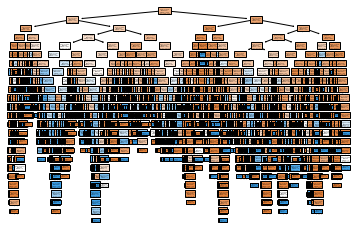

In [39]:
_ = tree.plot_tree(decision_tree,filled=True)

The tree is probably overfitted on the input. Testing for best max depth next

In [19]:
depth_stats = pd.DataFrame(index=range(1,21), columns=["accuracy", "precision", "recall"])
depth_stats
for i in range(1,21):
    depth_tree = DecisionTreeClassifier(max_depth = i)
    depth_tree.fit(train_X, train_labels)
    depth_tree_labels = depth_tree.predict(test_X)
    depth_stats["accuracy"][i] = accuracy_score(y_true=gold_labels, y_pred=depth_tree_labels)
    depth_stats["precision"][i] = precision_score(y_true=gold_labels, y_pred=depth_tree_labels, zero_division = 0)
    depth_stats["recall"][i] = recall_score(y_true=gold_labels, y_pred=depth_tree_labels)
depth_stats

,accuracy,precision,recall
1,0.3543,0.0000,0.0000
2,0.3543,0.0000,0.0000
3,0.3543,0.0000,0.0000
4,0.3543,0.0000,0.0000
5,0.3878,0.7009,0.0907
6,0.3856,0.7025,0.0843
7,0.3996,0.7042,0.1211
8,0.4312,0.6874,0.2187
9,0.4293,0.6751,0.2240
10,0.4310,0.6667,0.2377


After depth of 13, the increase of the statistics is marginal. This depth seems to be the best cutting off point. However, even with depth 13, the tree is still very hard to explain:

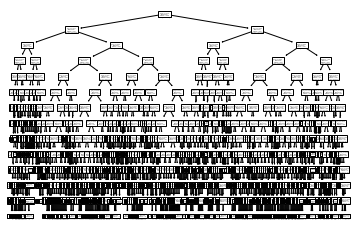

In [21]:
decision_tree_13 = DecisionTreeClassifier(max_depth = 13)
decision_tree_13.fit(train_X, train_labels)
_ = tree.plot_tree(decision_tree_13, filled = True)

Optimizing for `min_samples_split`next

In [39]:
split_stats = pd.DataFrame(index=np.arange(2,42, step=3), columns=["accuracy", "precision", "recall"])
for i in np.arange(2,42, step=3):
    split_tree = DecisionTreeClassifier(max_depth = 13, min_samples_split = i)
    split_tree.fit(train_X, train_labels)
    split_tree_labels = split_tree.predict(test_X)
    split_stats["accuracy"][i] = accuracy_score(y_true=gold_labels, y_pred=split_tree_labels)
    split_stats["precision"][i] = precision_score(y_true=gold_labels, y_pred=split_tree_labels, zero_division = 0)
    split_stats["recall"][i] = recall_score(y_true=gold_labels, y_pred=split_tree_labels)
split_stats

,accuracy,precision,recall
2,0.4604,0.6858,0.3033
5,0.4594,0.6864,0.2999
8,0.4678,0.6950,0.3132
11,0.4668,0.6967,0.3087
14,0.4690,0.6986,0.3125
17,0.4695,0.6952,0.3178
20,0.4656,0.6924,0.3102
23,0.4594,0.6844,0.3022
26,0.4570,0.6830,0.2969
29,0.4533,0.6833,0.2859


A value of 20 seems appropriate. Same testing for `min_samples_leaf`

In [41]:
leaf_stats = pd.DataFrame(index=np.arange(1,21), columns=["accuracy", "precision", "recall"])
for i in np.arange(1, 21):
    leaf_tree = DecisionTreeClassifier(max_depth = 13, min_samples_split = 20, min_samples_leaf = i)
    leaf_tree.fit(train_X, train_labels)
    leaf_tree_labels = leaf_tree.predict(test_X)
    leaf_stats["accuracy"][i] = accuracy_score(y_true=gold_labels, y_pred=leaf_tree_labels)
    leaf_stats["precision"][i] = precision_score(y_true=gold_labels, y_pred=leaf_tree_labels, zero_division = 0)
    leaf_stats["recall"][i] = recall_score(y_true=gold_labels, y_pred=leaf_tree_labels)
leaf_stats

,accuracy,precision,recall
1,0.4663,0.6945,0.3098
2,0.4692,0.6982,0.3136
3,0.4665,0.6941,0.3109
4,0.4521,0.6776,0.2889
5,0.4528,0.6779,0.2908
6,0.4479,0.6752,0.2794
7,0.4481,0.6785,0.2764
8,0.4486,0.6874,0.2680
9,0.4557,0.6949,0.2802
10,0.4479,0.6847,0.2688


9 seems best. Now to optimize in this range using grid search

In [8]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import scipy.stats as stats
from sklearn.utils.fixes import loguniform
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer

In [60]:
grid = {"max_depth": [11, 12, 13, 14, 15],
        "min_samples_split": [16, 18, 20, 22, 24],
        "min_samples_leaf": [7, 8, 9, 10, 11]
       }
searcher = GridSearchCV(DecisionTreeClassifier(), grid, n_jobs = -1, refit = "accuracy", scoring = ["accuracy", "precision", "recall"], verbose = 3)
searcher.fit(train_X, train_labels)

Fitting 5 folds for each of 125 candidates, totalling 625 fits


GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [11, 12, 13, 14, 15],
                         'min_samples_leaf': [7, 8, 9, 10, 11],
                         'min_samples_split': [16, 18, 20, 22, 24]},
             refit='accuracy', scoring=['accuracy', 'precision', 'recall'],
             verbose=3)

In [61]:
searcher.best_params_

{'max_depth': 11, 'min_samples_leaf': 10, 'min_samples_split': 24}

In [62]:
searcher.best_score_

0.6670558909483042

In [63]:
grid_tree_labels = searcher.best_estimator_.predict(test_X)
grid_tree_acc = accuracy_score(y_true=gold_labels, y_pred=grid_tree_labels)
grid_tree_prec = precision_score(y_true=gold_labels, y_pred=grid_tree_labels, zero_division = 0)
grid_tree_rec = recall_score(y_true=gold_labels, y_pred=grid_tree_labels)
print("accuracy:", grid_tree_acc, "precision:", grid_tree_prec, "recall:", grid_tree_rec)

accuracy: 0.44496200049031626 precision: 0.685370741482966 recall: 0.25968109339407747


The optimized decision tree - with measures taken against overfitting - now has slightly worse scores than the unoptimized SVM

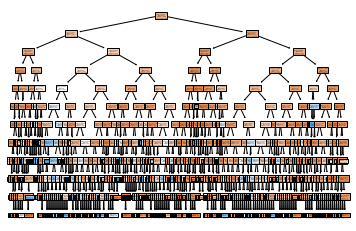

In [66]:
_ = tree.plot_tree(searcher.best_estimator_, filled = True)

#### Optimizing the SVM
By optimizing the SVM using random search or bayes search and then honing in using grid-search, the performance might be improved as well

In [31]:
X = twitter_binary_features_complex_fasttext
y = twitter_binary_labels
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.8, random_state=0)

Bayes-Search does absolutely not want to run on my machine. Would have been a great tool for optimization

In [ ]:
f2 = make_scorer(fbeta_score, beta=1.5)
opt = BayesSearchCV(SVC(),
        {'C': Real(1e-6, 1e+6, prior='log-uniform'),
         'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
         'degree': Integer(1,8),
         'kernel': Categorical(['linear', 'poly', 'rbf']),
        }, n_iter=20, scoring=f2, random_state=42, verbose=3)
print(opt.fit(X_train, y_train))
print(opt.score(X_test, y_test))

Random search in broad range of values also doesnt work, neither sequentially nor multithreaded ...

In [ ]:
f2 = make_scorer(fbeta_score, beta=1.5)
random_search_dist = {"C": stats.uniform(0.1, 1e4), 
                      "gamma": loguniform(1e-6, 1e+1),
                      "kernel": ["linear", "poly", "rbf"],
                      "degree": [4, 5, 6, 7]}
random_svm = RandomizedSearchCV(SVC(), cv = 3, scoring=f2, param_distributions=random_search_dist, n_iter=30, refit=True, verbose=3)
random_svm.fit(X_train, y_train)

Instead, an exhaustive grid search is performed over all possible (sensible) values. 
Because the SVM tends to struggle with recall more than with precision and it also can fit to achieve really high accuracy with low number of positive  predictions at all (thus tanking precision and recall scores), an f1.5 scorer is chosen to optimize for.

In [29]:
grid_svm = {'C': [5, 10, 50, 100], 
            'gamma': [0.01, 0.005, 0.001, 0.0005],
            'kernel': ['rbf', 'poly', 'sigmoid']}
searcher_svm = GridSearchCV(SVC(degree=6), grid_svm, cv = 3, n_jobs = -1, refit = f2, scoring = {"accuracy": make_scorer(accuracy_score), "precision": make_scorer(precision_score), "recall": make_scorer(recall_score), "f1.5": f2}, verbose = 3)
searcher_svm.fit(X, y)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


TypeError: __call__() missing 2 required positional arguments: 'X' and 'y_true'

Refitting failed, but extracting the best params from the console is still possible. However, cross-validation cannot taken into account here any longer because of that, so the search result might be slightly off. Testing with a manual 5-fold CV

In [32]:
kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X)
svm_valid = None
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    svm_valid = SVC(kernel="rbf", C=100, gamma=0.005)
    svm_valid.fit(X_train, y_train)
    valid_labels = svm_valid.predict(X_test)
    valid_acc = accuracy_score(y_true=y_test, y_pred=valid_labels)
    valid_prec = precision_score(y_true=y_test, y_pred=valid_labels, zero_division = 0)
    valid_rec = recall_score(y_true=y_test, y_pred=valid_labels)
    print("accuracy:", valid_acc, "precision:", valid_prec, "recall:", valid_rec)

accuracy: 0.7168423633243443 precision: 0.6118577075098814 recall: 0.5382475660639777
accuracy: 0.7300147130946543 precision: 0.6230191826522101 recall: 0.5351002865329513
accuracy: 0.7312408043158412 precision: 0.6125490196078431 recall: 0.5647143890093999
accuracy: 0.7390877881314369 precision: 0.6560669456066945 recall: 0.5455810716771051
accuracy: 0.7300147130946543 precision: 0.6431535269709544 recall: 0.5359612724757953


Compare that to the results of the optimized Decision tree:

In [33]:
kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X)
decision_tree_valid = None
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    decision_tree_valid = DecisionTreeClassifier(max_depth= 11, min_samples_leaf= 10, min_samples_split= 24)
    decision_tree_valid.fit(X_train, y_train)
    valid_labels = decision_tree_valid.predict(X_test)
    valid_acc = accuracy_score(y_true=y_test, y_pred=valid_labels)
    valid_prec = precision_score(y_true=y_test, y_pred=valid_labels, zero_division = 0)
    valid_rec = recall_score(y_true=y_test, y_pred=valid_labels)
    print("accuracy:", valid_acc, "precision:", valid_prec, "recall:", valid_rec)

accuracy: 0.6533464084334396 precision: 0.5057736720554272 recall: 0.45976207137858643
accuracy: 0.6777832270720942 precision: 0.54178145087236 recall: 0.4199288256227758
accuracy: 0.6755762628739578 precision: 0.5711361310133061 recall: 0.3816689466484268
accuracy: 0.6738597351642962 precision: 0.5380483437779767 recall: 0.42473498233215545
accuracy: 0.6714075527219225 precision: 0.52046783625731 recall: 0.44852411807055437


The SVM seems to yield significantly better results than the decision tree that are also uniformly reliable (relatively even over all three scores). However, the classifier is vastly more costly, taking around 100x the training time. Since SVCs scale quadratically with input samples, a linear support vector machine might be more efficient - especially if a larger database might present itself in the future -, but less robust. Both the decision tree and the SVM will be used for further tasks

#### Analyzing features
Now to analyze the feature space. If there are some low-variance features, they are probably unnecessary and better be removed 

In [216]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, f_regression, r_regression
analysis_features = np.array([vectorize(tweet, features=["fasttext", "punctuation", "hashtag", "retweet", "caps", "emoji"]) for tweet in df["post"]])
feature_names = ["embedding " + str(n) for n in range(300)] + ["num of " + p for p in [".", "...", ",", "(", ")", ":", ";", '""', "#"]] + ["is retweet", "CAPS ratio", "num of emojis"]

Which features are least important for the decision tree classifier?

In [119]:
tree_importances = pd.DataFrame([[feature_names[f], np.sort(decision_tree_valid.feature_importances_)[i]] for i, f in enumerate(np.argsort(decision_tree_valid.feature_importances_))], columns = ["feature", "importance"])
tree_importances[115:]

,feature,importance
115,embedding 41,0.0000
116,embedding 289,0.0000
117,num of .,0.0000
118,embedding 292,0.0000
119,embedding 158,0.0001
...,...,...
307,embedding 213,0.0188
308,embedding 135,0.0232
309,embedding 32,0.0260
310,embedding 194,0.0557


In [132]:
list(tree_importances.loc[:,"feature"])[119:]

['embedding 158',
 'embedding 153',
 'embedding 126',
 'embedding 26',
 'embedding 94',
 'embedding 148',
 'embedding 200',
 'embedding 156',
 'embedding 281',
 'embedding 182',
 'is retweet',
 'embedding 243',
 'embedding 84',
 'embedding 155',
 'embedding 56',
 'embedding 82',
 'embedding 58',
 'embedding 2',
 'embedding 212',
 'embedding 271',
 'embedding 91',
 'embedding 7',
 'embedding 13',
 'embedding 70',
 'embedding 179',
 'embedding 35',
 'embedding 287',
 'embedding 49',
 'embedding 116',
 'embedding 196',
 'embedding 208',
 'embedding 23',
 'embedding 256',
 'embedding 83',
 'embedding 188',
 'embedding 25',
 'embedding 110',
 'embedding 16',
 'embedding 222',
 'embedding 190',
 'embedding 146',
 'embedding 276',
 'embedding 233',
 'embedding 75',
 'embedding 95',
 'embedding 15',
 'embedding 178',
 'embedding 73',
 'embedding 252',
 'embedding 247',
 'embedding 203',
 'embedding 21',
 'embedding 125',
 'embedding 191',
 'embedding 282',
 'embedding 109',
 'embedding 269',
 

Most of the surface features aren't relevant to the Decision tree and it is perfectly capable relying on mostly semantic features. The only exceptional indicators are `is retweet` and `contains ,` of which one is very plausible and the other is very surprising. Indeed, with an importance of over 0.2, the use of comma is the single strongest feature for the decision tree ...

Now to analyze the features with some statistical tools

In [151]:
feature_variances = pd.DataFrame([[feature_names[f], np.sort(np.var(analysis_features, axis=0))[i]] for i, f in enumerate(np.argsort(np.var(analysis_features, axis=0)))], columns = ["feature", "variance"])

In [155]:
with pd.option_context('display.min_rows', 20):
    display(feature_variances)

,feature,variance
0,num of emojis,0.0000
1,"num of """"",0.0000
2,embedding 7,0.0001
3,embedding 146,0.0001
4,embedding 55,0.0001
5,embedding 202,0.0001
6,embedding 214,0.0001
7,embedding 51,0.0001
8,embedding 85,0.0001
9,embedding 112,0.0001


Emojis and quotation marks are useless as features because they are filtered out of the text beforehand. Otherwise, surface features are very high in variance when compared to the embeddings. This is also because here, the features are not normalized, so of course, occurence counts will vary more strongly than semantic embedding vectors. In regards to the vectors, their significance is also not uniform or random. Some dimensions seem more important than others

In [163]:
from matplotlib import pyplot

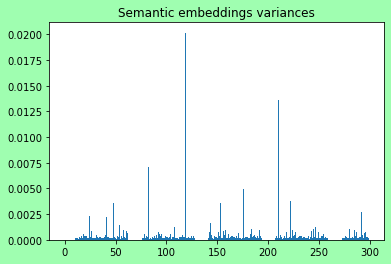

In [192]:
pyplot.figure(facecolor="xkcd:mint")
pyplot.bar(range(300), np.var(analysis_features, axis=0)[:300])
pyplot.title("Semantic embeddings variances")
pyplot.show()

In [219]:
k_best = SelectKBest(r_regression, k=300)
k_best.fit(analysis_features, y)
k_best_removed = k_best.get_support()
[print(feature_names[i]) for i in range(312) if k_best_removed[i] == False]

embedding 60
embedding 61
embedding 135
embedding 151
embedding 157
embedding 163
embedding 164
embedding 194
embedding 254
embedding 275
num of ""
num of emojis


C:\Users\flohk\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[None, None, None, None, None, None, None, None, None, None, None, None]

After evaluating the feature space using Pearson correlation, it seems best to keep all the surface features in. Although the decision tree didn't mind most of them for decision making, the inclusion of the extra features was (if only slightly) beneficial to the estimators. There is also high variance, but that might also just be noisy. However, quotation mark and emoji counter will be removed in the further process.